In [1]:
# Imports
from dask_mongo import read_mongo, to_mongo
from dask.distributed import Client

The Client registers itself as the default Dask scheduler, and so runs all dask collections like dask.array, dask.bag, dask.dataframe and dask.delayed

In [6]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50914,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.88 GiB
Comm: tcp://127.0.0.1:50946,Total threads: 1
Dashboard: http://127.0.0.1:50947/status,Memory: 3.97 GiB
Nanny: tcp://127.0.0.1:50919,


# Dask Dataframe

In [7]:
import pandas as pd
import dask.dataframe as ddf
import dask.bag as db

In [8]:
train_data = ddf.read_csv(r'G:\CDAC\Project Data\amex-default-prediction\train_data.csv')
train_data.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217


In [9]:
target_df = ddf.read_csv(r'G:\CDAC\Project Data\amex-default-prediction\train_labels.csv')
target_df.head(2)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [10]:
merged_df = train_data.merge(target_df, on='customer_ID', how='inner', npartitions=4)
merged_df.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0


In [11]:
merged_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 191 entries, customer_ID to target
dtypes: object(4), float64(185), int64(2)

In [ ]:
import gc

del train_data
del target_df
gc.collect()

# Write to MongoDB using dask-mongo
- Convert Dask data frame to a Dask Bag
- Use to_mongo to write to the desired database

In this example we will convert the Dask DataFrame we just created and write it to a new database in our MongoDB 

In [2]:
host_uri = 'mongodb://localhost:27017'

In [14]:
new_bag = merged_df.to_bag(index=False, format='dict')
new_bag.take(2)

({'customer_ID': '0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a',
  'S_2': '2017-03-09',
  'P_2': 0.9384687191272548,
  'D_39': 0.0017333390041739,
  'B_1': 0.0087244509498605,
  'B_2': 1.0068382339663076,
  'R_1': 0.0092277222786689,
  'S_3': 0.1240351558143743,
  'D_41': 0.0087711319938824,
  'B_3': 0.0047092406313857,
  'D_42': nan,
  'D_43': nan,
  'D_44': 0.0006301348049115,
  'B_4': 0.0809863324662527,
  'D_45': 0.708906305121159,
  'B_5': 0.1706002293387026,
  'R_2': 0.0062040314303209,
  'D_46': 0.3585865793715965,
  'D_47': 0.525351040810055,
  'D_48': 0.255736073902975,
  'D_49': nan,
  'B_6': 0.0639022133803909,
  'B_7': 0.0594157330614109,
  'B_8': 0.006465576798311,
  'D_50': 0.1486979558199995,
  'D_51': 1.3358557940752642,
  'B_9': 0.0082067391252636,
  'R_3': 0.0014225021561254,
  'D_52': 0.2073338786110817,
  'P_3': 0.7364627260945562,
  'B_10': 0.0962188066642168,
  'D_53': nan,
  'S_5': 0.0233811220509184,
  'B_11': 0.0027680616648439,
  'S_6': 0.0

In [ ]:
to_mongo(
    new_bag,
    database='amex',
    collection='train_data',
    connection_kwargs={'host': host_uri},
)

In [ ]:
del new_bag
del merged_df
gc.collect()

# Read Data From MongoDB

In [3]:
read_data = read_mongo(
    connection_kwargs={"host": host_uri},
    database="amex",
    collection="train_data",
    chunksize=5000,
)

In [4]:
read_data.take(1)

({'_id': ObjectId('632ad36d65c75e7705ac38d1'),
  'customer_ID': '0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a',
  'S_2': '2017-03-09',
  'P_2': 0.9384687191272548,
  'D_39': 0.0017333390041739,
  'B_1': 0.0087244509498605,
  'B_2': 1.0068382339663076,
  'R_1': 0.0092277222786689,
  'S_3': 0.1240351558143743,
  'D_41': 0.0087711319938824,
  'B_3': 0.0047092406313857,
  'D_42': nan,
  'D_43': nan,
  'D_44': 0.0006301348049115,
  'B_4': 0.0809863324662527,
  'D_45': 0.708906305121159,
  'B_5': 0.1706002293387026,
  'R_2': 0.0062040314303209,
  'D_46': 0.3585865793715965,
  'D_47': 0.525351040810055,
  'D_48': 0.255736073902975,
  'D_49': nan,
  'B_6': 0.0639022133803909,
  'B_7': 0.0594157330614109,
  'B_8': 0.006465576798311,
  'D_50': 0.1486979558199995,
  'D_51': 1.3358557940752642,
  'B_9': 0.0082067391252636,
  'R_3': 0.0014225021561254,
  'D_52': 0.2073338786110817,
  'P_3': 0.7364627260945562,
  'B_10': 0.0962188066642168,
  'D_53': nan,
  'S_5': 0.0233811220509

# Sampling the dataset

In [7]:
type(read_data)

dask.bag.core.Bag

In [5]:
train_data = read_data.to_dataframe(optimize_graph=True)
type(train_data)

dask.dataframe.core.DataFrame

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.153112 to fit


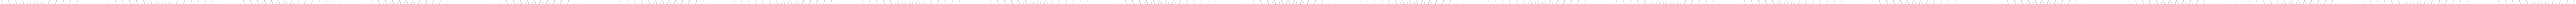

In [18]:
train_data.visualize()

In [6]:
train_data.head()

,_id,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,632ad36d65c75e7705ac38d1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,632ad36d65c75e7705ac38d2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,632ad36d65c75e7705ac38d3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,632ad36d65c75e7705ac38d4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,632ad36d65c75e7705ac38d5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


In [19]:
train_data.tail()

,_id,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
4764,632adc4061ce2ca7108d53b0,5fc68b8de6ea315367eec4d46029d4bc5065dce7e8a854...,2017-09-20,0.541897,0.508603,0.199352,0.109469,0.007329,0.080251,0.003201,...,NaN,NaN,0.003226,0.004033,0.005693,NaN,0.003726,0.008128,0.000248,1
4765,632adc4061ce2ca7108d53b1,5fc68b8de6ea315367eec4d46029d4bc5065dce7e8a854...,2017-10-14,0.588063,0.330459,0.187690,0.105895,0.013739,0.083701,0.000937,...,NaN,NaN,0.004518,0.001831,0.002806,NaN,0.009946,0.002894,0.001557,1
4766,632adc4061ce2ca7108d53b2,5fc68b8de6ea315367eec4d46029d4bc5065dce7e8a854...,2017-11-07,0.586002,0.120781,0.190667,0.084084,0.000572,0.079288,0.009489,...,NaN,NaN,0.005744,0.000770,0.003615,NaN,0.002452,0.006660,0.006537,1
4767,632adc4061ce2ca7108d53b3,5fc68b8de6ea315367eec4d46029d4bc5065dce7e8a854...,2017-12-21,0.588441,0.329402,0.228725,0.067009,0.000635,0.090600,0.002086,...,NaN,NaN,0.000246,0.001958,0.008537,NaN,0.009182,0.005895,0.007955,1
4768,632adc4061ce2ca7108d53b4,5fc68b8de6ea315367eec4d46029d4bc5065dce7e8a854...,2018-01-21,0.537032,0.332467,0.241950,0.080258,0.002273,0.092380,0.004232,...,NaN,NaN,0.007094,0.004423,0.009051,NaN,0.009276,0.007390,0.002115,1


No Conflict of datatypes

Compute this dask collection

This turns a lazy Dask collection into its in-memory equivalent. For example a Dask array turns into a NumPy array and a Dask dataframe turns into a Pandas dataframe. The entire dataset must fit into memory before calling this operation.

% % time
train_data.compute()

In [21]:
# train_data.drop(labels='_id', axis=1)
train_data.columns

Index(['_id', 'customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3',
       'D_41',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=192)

In [22]:
print(train_data.shape)

(Delayed('int-80b15470-1fc0-4105-adfd-094539247ca5'), 192)


from cochran_sampling import stratified_sample

stratified_df = stratified_sample(df=train_data, seed=100, strata=['target'], size=0.02)
del train_data
gc.collect()
print(type(stratified_df))
print(stratified_df.shape)

- NotImplementedMethodError: 'around' is not implemented for Dask.series.Series objects

In [9]:
# stratified sampling using dask
def stratified_sample(df, seed, strata, size):
    batch = df.groupby(strata).apply(lambda x: x.sample(frac=size, random_state=seed))
    yield batch.compute()

In [10]:
stratified_df = stratified_sample(df=train_data, seed=100, strata=['target'], size=0.02)

In [11]:
type(stratified_df)

generator

In [12]:
import pandas as pd
sample_df = pd.concat(stratified_df, ignore_index=True)

C:\Users\SRA_31N583\AppData\Local\Temp\ipykernel_7556\3652000432.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  batch = df.groupby(strata).apply(lambda x: x.sample(frac=size, random_state=seed))


In [14]:
sample_df.shape

(112358, 192)

In [15]:
type(sample_df)

pandas.core.frame.DataFrame

In [40]:
# Converting persisted dask dataframe to pandas dataframe
sample_df.compute()

2022-09-22 01:03:16,904 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:62474 (pid=6832) exceeded 95% memory budget. Restarting...
2022-09-22 01:03:17,282 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:62474 (pid=6832) is slow to terminate; trying again
Future exception was never retrieved
future: <Future finished exception=PermissionError(13, 'Access is denied', None, 5, None)>
Traceback (most recent call last):
  File "c:\Program Files\Python310\lib\site-packages\distributed\process.py", line 38, in _call_and_set_future
    res = func(*args, **kwargs)
  File "c:\Program Files\Python310\lib\multiprocessing\process.py", line 140, in kill
    self._popen.kill()
  File "c:\Program Files\Python310\lib\multiprocessing\popen_spawn_win32.py", line 123, in terminate
    _winapi.TerminateProcess(int(self._handle), TERMINATE)
PermissionError: [WinError 5] Access is denied
2022-09-22 01:03:30,101 - distributed.nanny - WARNING - Restarting worker


In [ ]:
import gc
del read_data
del train_data
gc.collect()

In [20]:
sample_df.to_csv(r'G:\CDAC\Project Data\amex-default-prediction\train_data_sample.csv', index=False)

In [ ]:
# remove index column 
sample_df.drop(labels='_id', axis=1, inplace=True)

In [ ]:
sample_df.set_index('customer_ID', inplace=True)
sample_df.head()

In [26]:
sample_df.head() , sample_df.shape

(                                                           S_2       P_2  \
 customer_ID                                                                
 c044d0bbe6656fa585004e111997543b5236727706b0889...  2017-09-30  0.291855   
 ddebb5b9eb62908f8baf0d9e03cd605df6251668f4120e4...  2017-03-10  0.485020   
 1d67549a899c28db58470432a1319b39296da6400256e34...  2017-09-09  0.445496   
 daa1eb3b98e14d77004a72ca49010ee101269ba80fda1a4...  2017-11-10  0.547825   
 ab021478d4dfba1b97b53aa8578d723e7e472e5085da05e...  2017-07-05  0.216784   
 
                                                         D_39       B_1  \
 customer_ID                                                              
 c044d0bbe6656fa585004e111997543b5236727706b0889...  0.005550  0.043770   
 ddebb5b9eb62908f8baf0d9e03cd605df6251668f4120e4...  0.004696  0.041810   
 1d67549a899c28db58470432a1319b39296da6400256e34...  0.037581  0.307431   
 daa1eb3b98e14d77004a72ca49010ee101269ba80fda1a4...  0.739172  0.042897   
 ab021478

# Data Preprocessing

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

* D_* = Delinquency variables (bad or criminal behaviour, especially among young people)
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables

with the following features being categorical: ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [294]:
train_df = sample_df.copy()

In [29]:
train_df.info(max_cols=190, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 112358 entries, c044d0bbe6656fa585004e111997543b5236727706b08892140bdcd47fe76be2 to fea45a6114dd54f3458614f0417cb08e9c8e8a668a1195dfc2914f48fc6801b6
Data columns (total 190 columns):
 #    Column  Non-Null Count   Dtype  
---   ------  --------------   -----  
 0    S_2     112358 non-null  object 
 1    P_2     111439 non-null  float64
 2    D_39    112358 non-null  float64
 3    B_1     112358 non-null  float64
 4    B_2     112316 non-null  float64
 5    R_1     112358 non-null  float64
 6    S_3     91622 non-null   float64
 7    D_41    112316 non-null  float64
 8    B_3     112316 non-null  float64
 9    D_42    16150 non-null   float64
 10   D_43    78718 non-null   float64
 11   D_44    106849 non-null  float64
 12   B_4     112358 non-null  float64
 13   D_45    112316 non-null  float64
 14   B_5     112358 non-null  float64
 15   R_2     112358 non-null  float64
 16   D_46    87670 non-null   float64
 17   D_47    112358 non-null  

In [31]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

num_cols = [col for col in train_df.columns if col not in categorical_cols + ["target"]]

print(f'Total number of features: {1}')
print(f'Total number of categorical features: {len(categorical_cols)}')
print(f'Total number of continuos features: {len(num_cols)}')

Total number of features: 1
Total number of categorical features: 11
Total number of continuos features: 178


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Visualizing the target variable

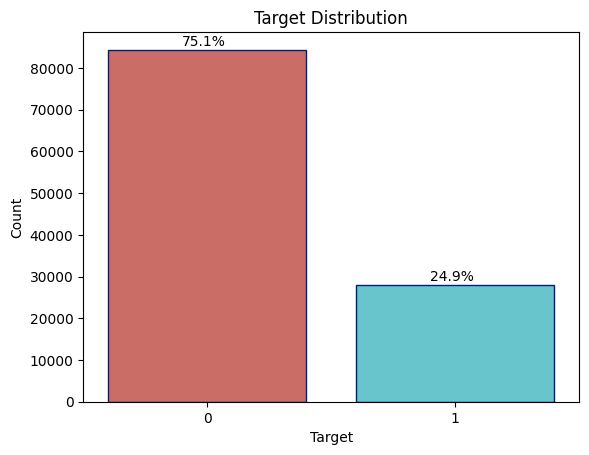

In [35]:
%matplotlib inline
ax = sns.countplot(x = 'target', data = train_df, palette = 'hls', edgecolor = sns.color_palette('dark', n_colors = 1))
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(train_df)), (p.get_x()+0.3, p.get_height()+1000))
plt.xticks([0, 1], ['0', '1'])
plt.ylabel('Count')
plt.xlabel('Target')
plt.title('Target Distribution')
plt.show()

### Visualizing the categorical variables

In [45]:
temp_val = pd.DataFrame(train_df['B_38'].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
temp_val.index.name = 'value'
temp_val.reset_index(inplace=True)
temp_val

,value,count
0,1.0,0.209073
1,2.0,0.351671
2,3.0,0.229285
3,4.0,0.053009
4,5.0,0.081223
5,6.0,0.028516
6,7.0,0.046850
7,NaN,0.000374


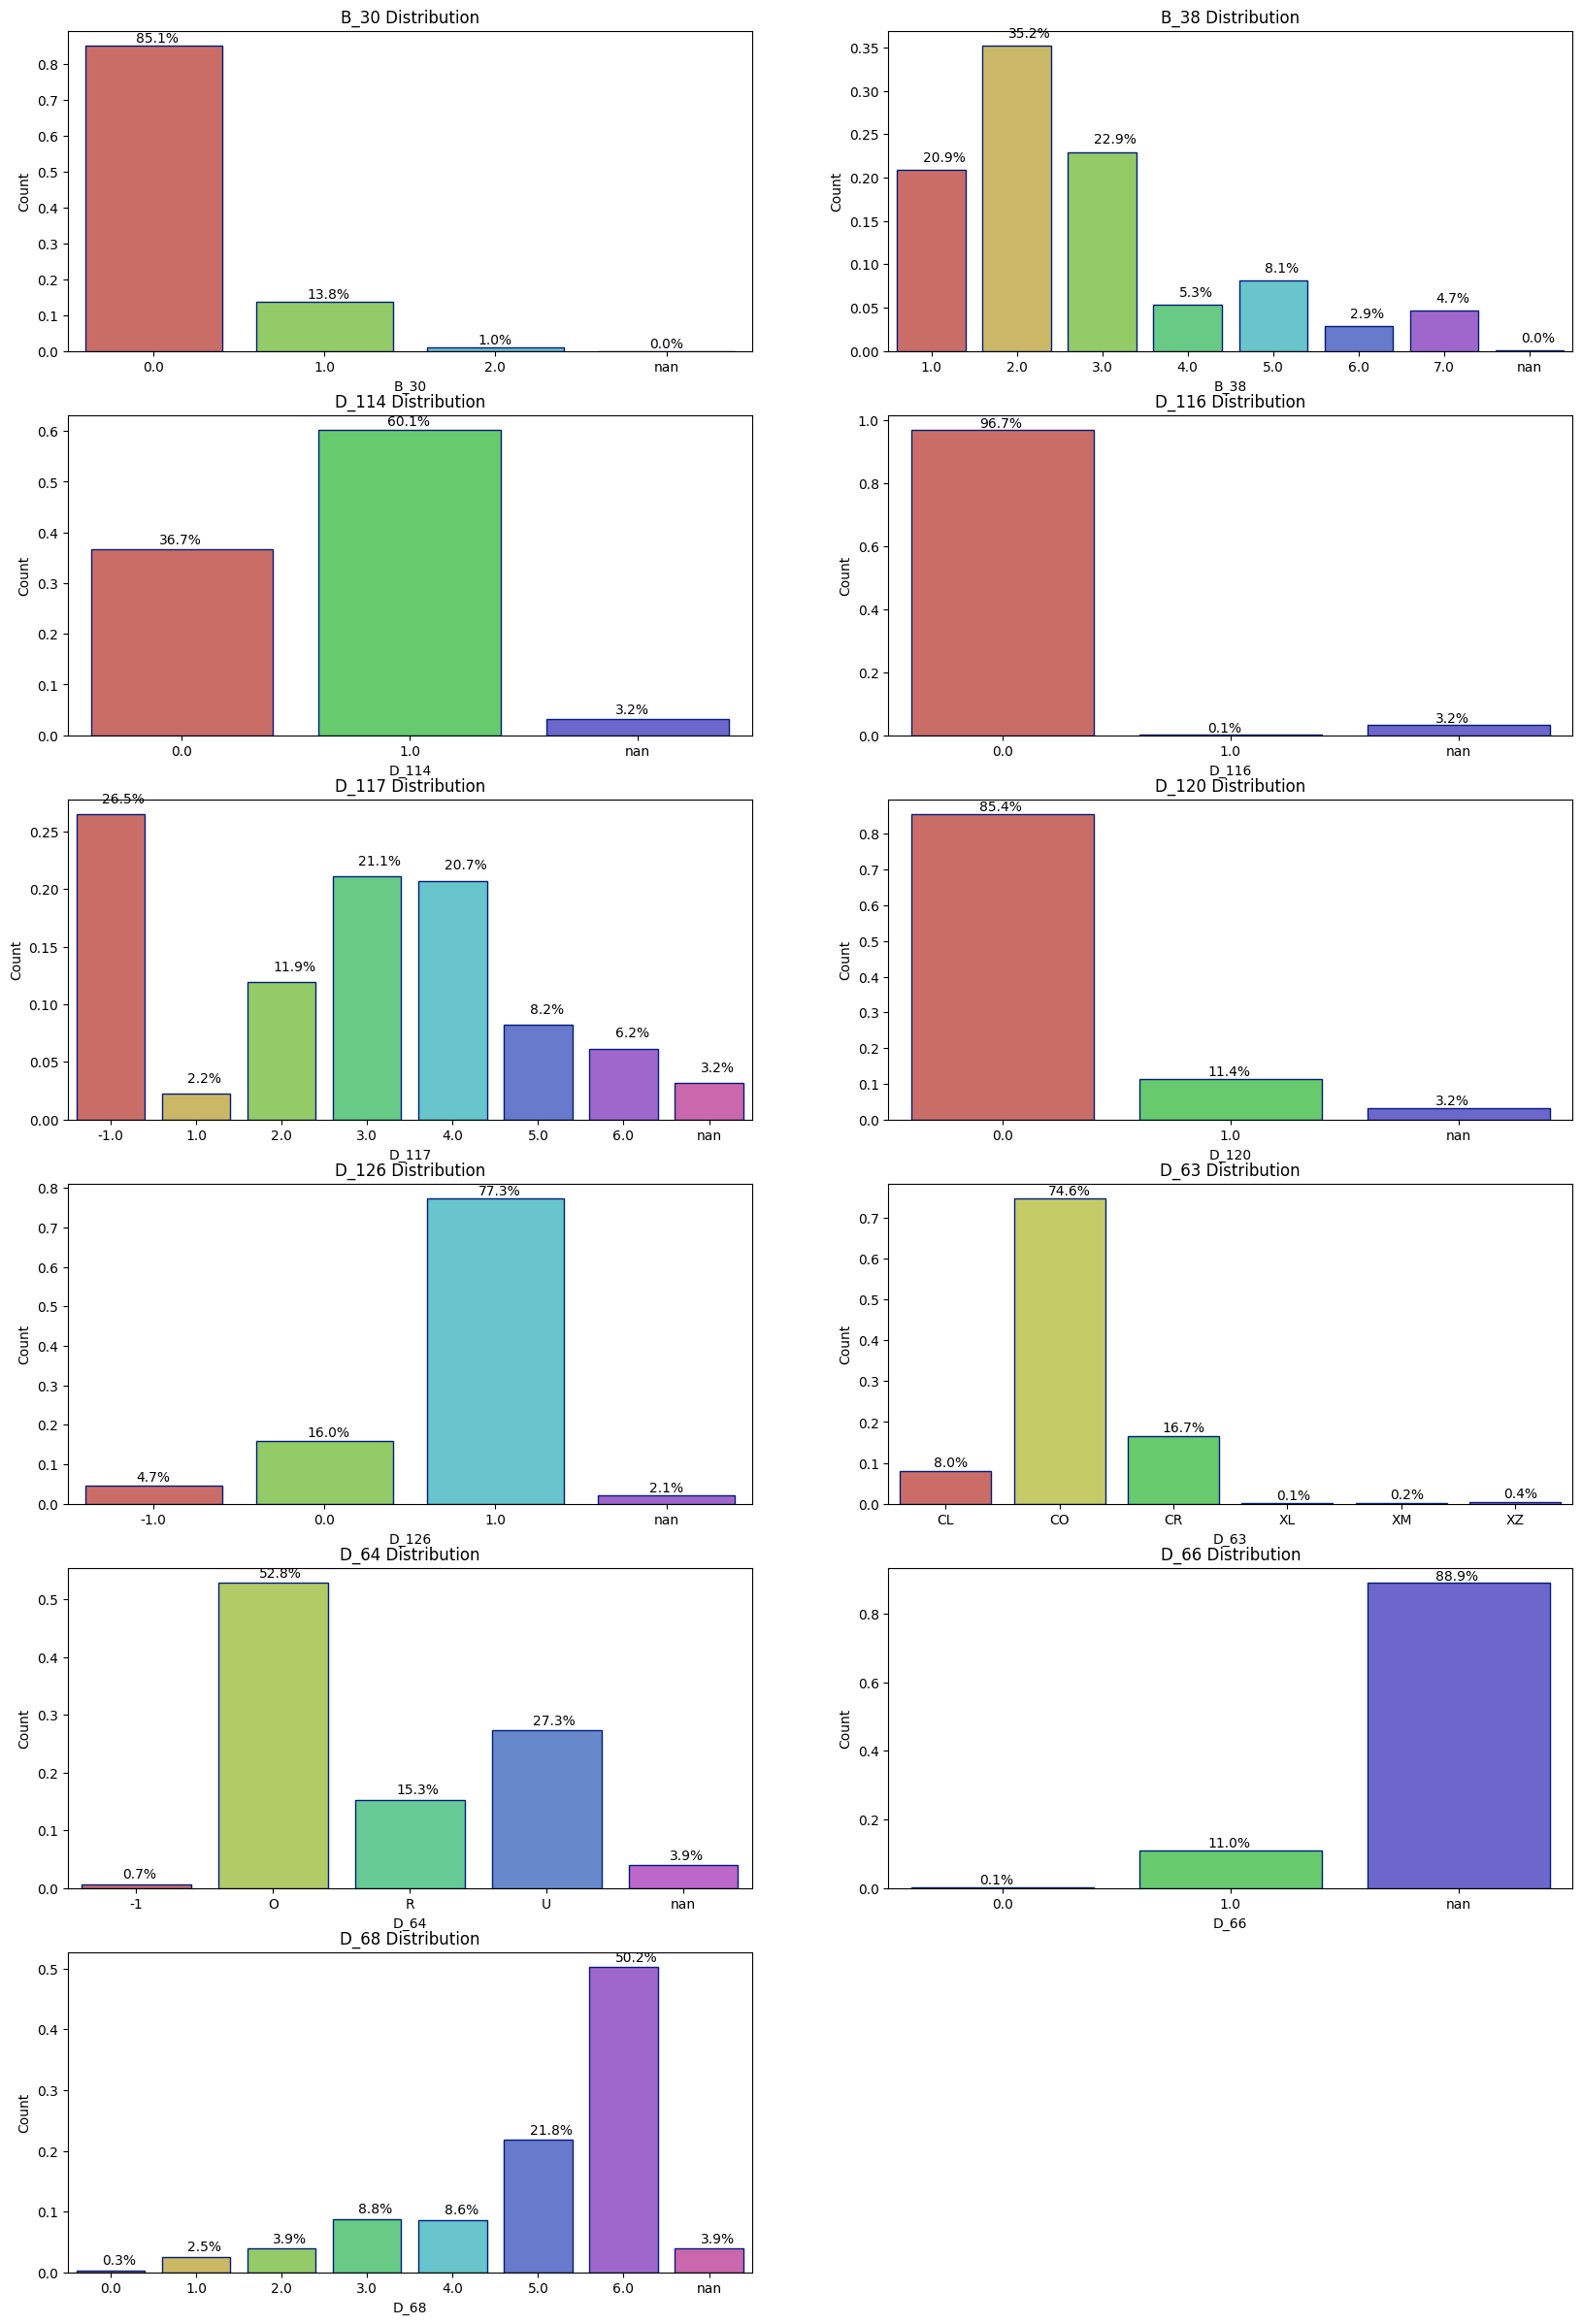

In [59]:
plt.figure(figsize=(20, 30))
for i, col in enumerate(categorical_cols):
    plt.subplot(6, 2, i+1)
    temp_val = pd.DataFrame(train_df[col].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp_val.index.name = 'value'
    temp_val.reset_index(inplace=True)
    temp_val['value'] = temp_val['value'].astype(str)
    ax = sns.barplot(x='value', y='count', data=temp_val, palette='hls', edgecolor=sns.color_palette('dark', n_colors=1))
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()), (p.get_x()+0.3, p.get_height()+0.01))
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.title(col + ' Distribution')
plt.show()
del temp_val

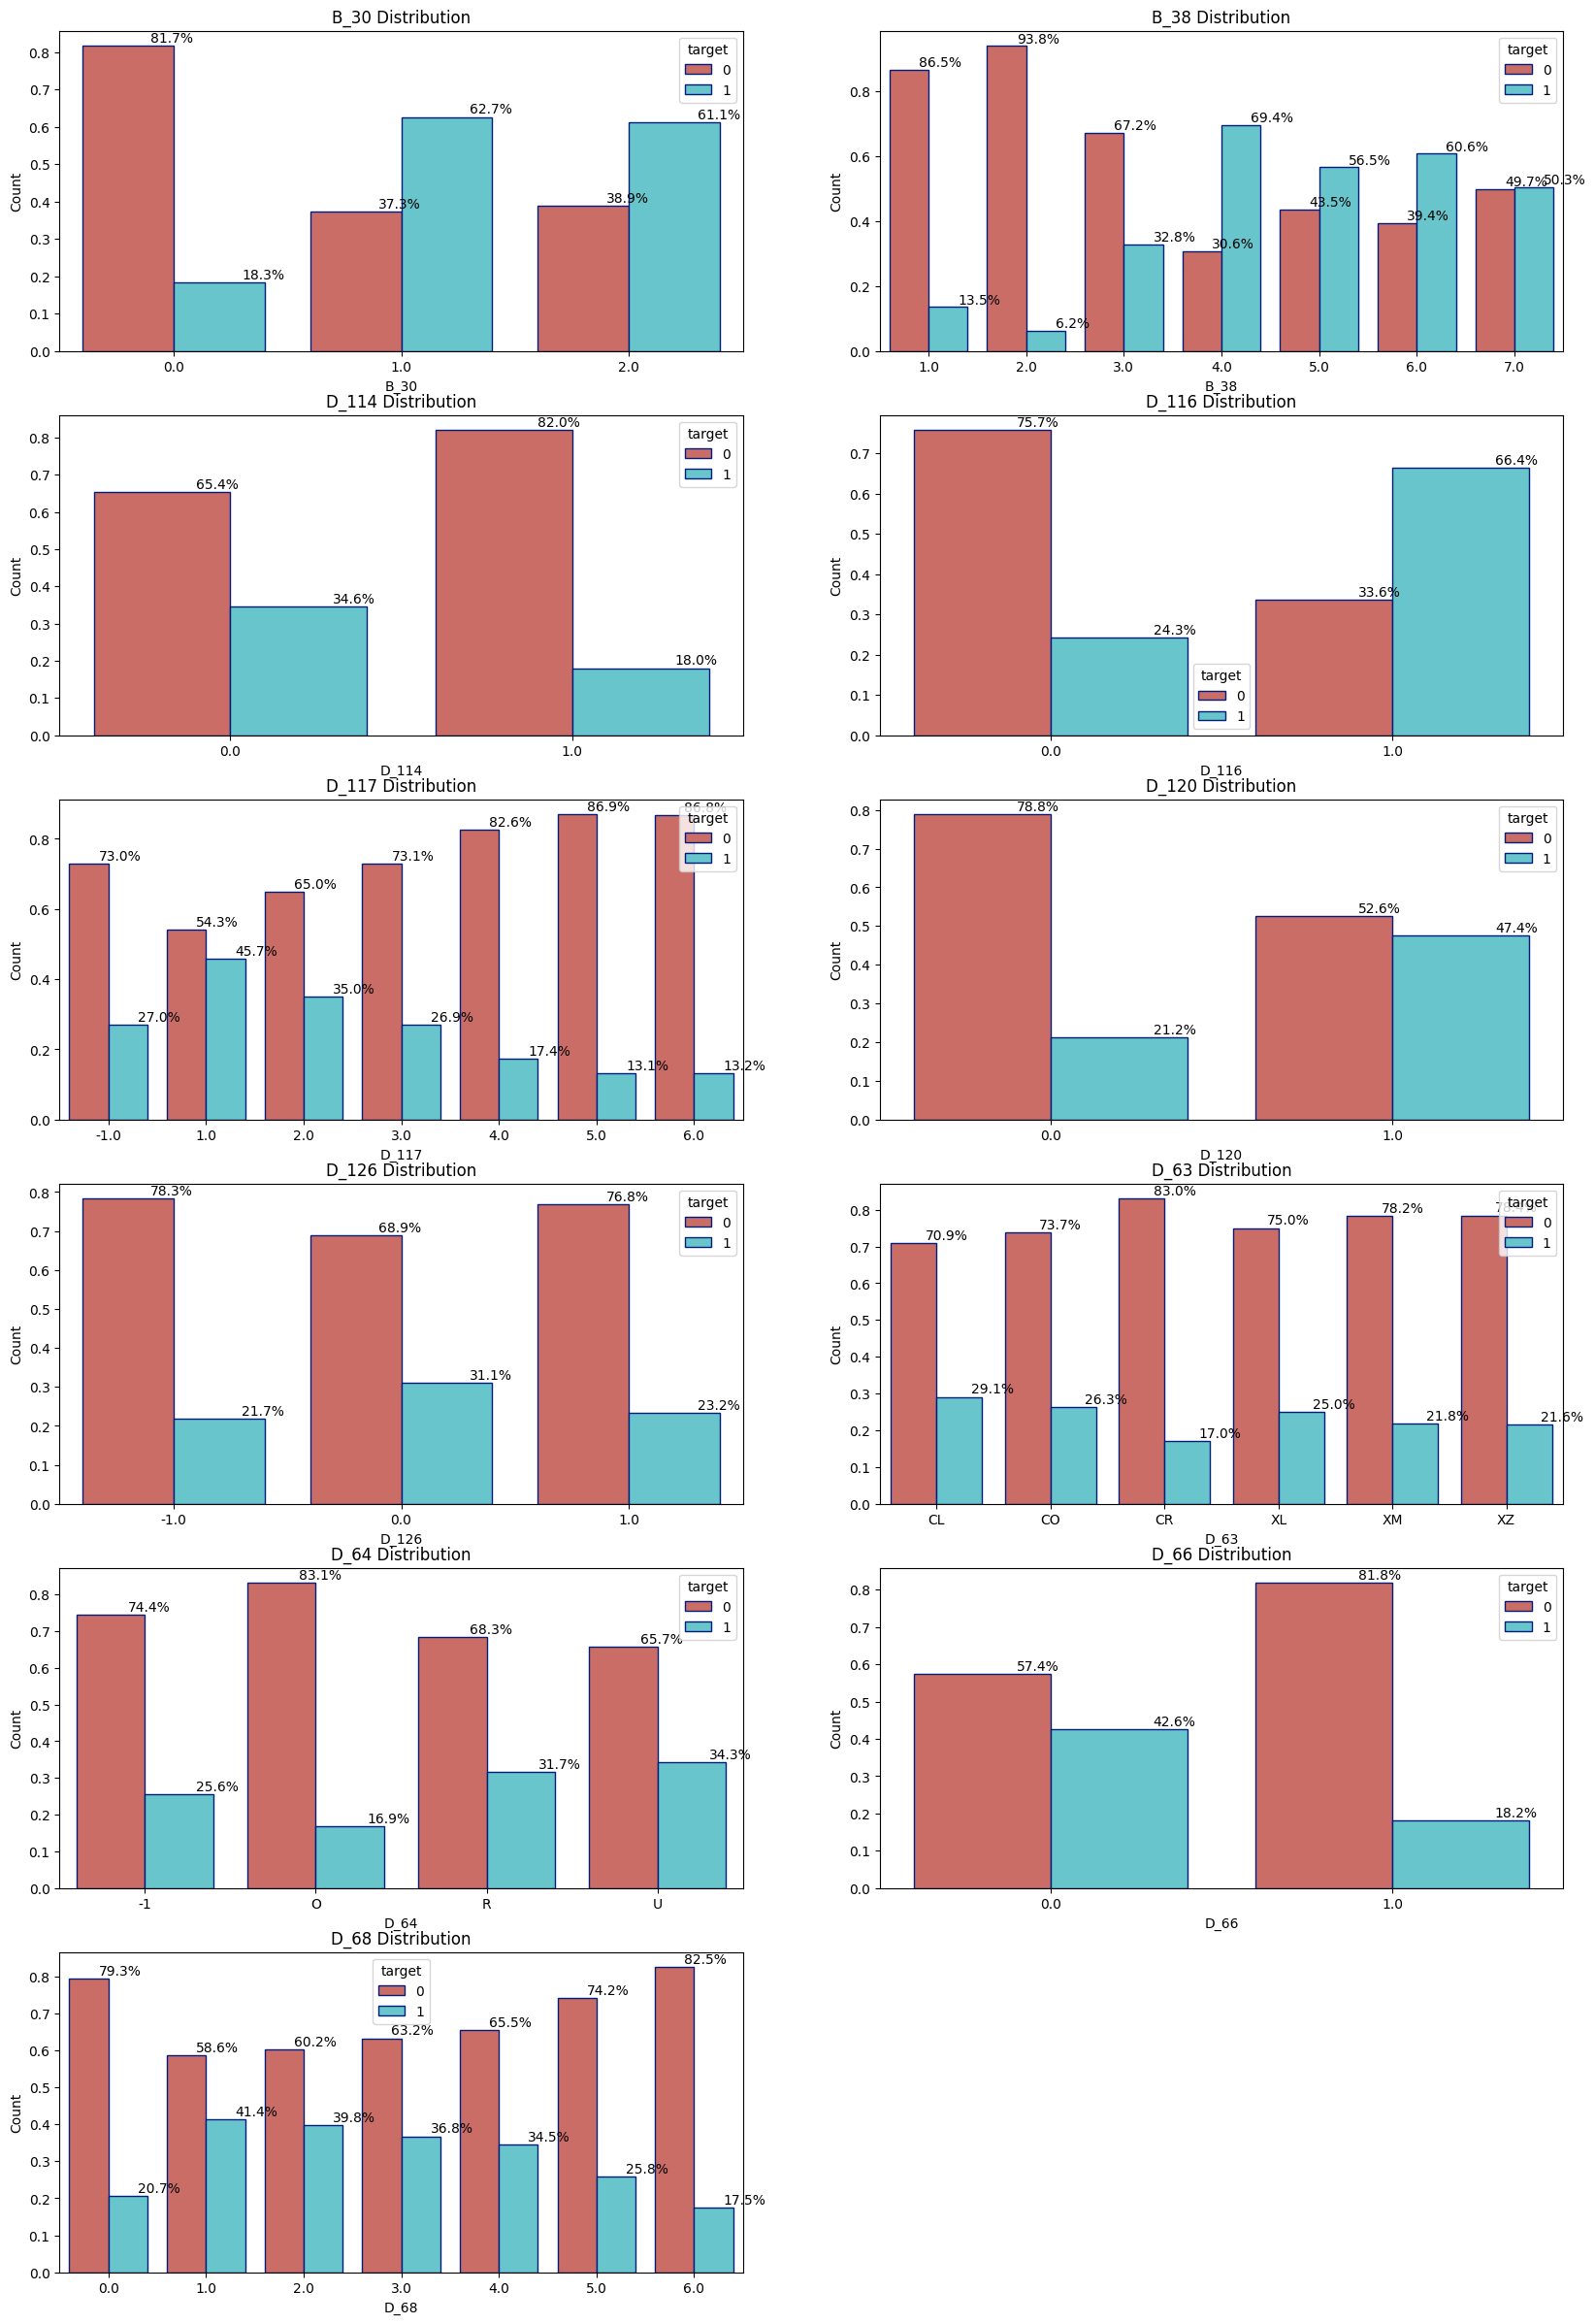

In [60]:
# Pairplot of categorical features with target
plt.figure(figsize=(20, 30))
for i,col in enumerate(categorical_cols):
    plt.subplot(6, 2, i+1)
    temp_val = pd.DataFrame(train_df.groupby(col)['target'].value_counts(normalize=True).rename('count'))
    temp_val.index.names = ['value', 'target']
    temp_val.reset_index(inplace=True)
    temp_val['value'] = temp_val['value'].astype(str)
    ax = sns.barplot(x='value', y='count', hue='target', data=temp_val, palette='hls', edgecolor=sns.color_palette('dark', n_colors=1))
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()), (p.get_x()+0.3, p.get_height()+0.01))
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.title(col + ' Distribution')

In [ ]:
# removing S_2 column
num_cols.remove('S_2')

In [263]:
# distplot of numerical features
def my_plot_grid(df, cols, plot_type, bins=None, kde=False, hist=True, rug=False, figsize=(20, 3), hue=None):
    """"
    Plots a grid of plots of the given type.
    
    PARAMETERS:
    plot_type: 'distplot', 'boxplot', 'violinplot'
    kde: kernel density estimation
    bins: number of bins
    rug: draw a rugplot on the support axis
    
    RETURNS: None
    """
    for i,col in enumerate(num_cols):
        if i % 4 == 0:
            if i > 0:
                plt.show()
            plt.figure(figsize=figsize)
        plt.subplot(1, 4, i % 4 + 1)
        if plot_type == 'histplot':
            ax = sns.histplot(df[col], bins=bins, kde=kde, hue=hue, line_kws={'lw':3,'ls':'--','color':'r'})
            # ax.lines[0].set_color('r') # set color of kde line //list index out of range error
        if plot_type == 'boxplot':
            sns.boxplot(x=df[col], orient='v', color='lightblue',notch=True, showcaps=False,
                        flierprops={"marker": "x"},
                        boxprops={"facecolor": (.4, .6, .8, .5)},
                        medianprops={"color": "coral"},)
        plt.xlabel('')
        plt.ylabel('Distribution')
        plt.title(plot_type + ' of ' + col)
        plt.tight_layout()
    plt.show()

In [264]:
gc.collect()

5182

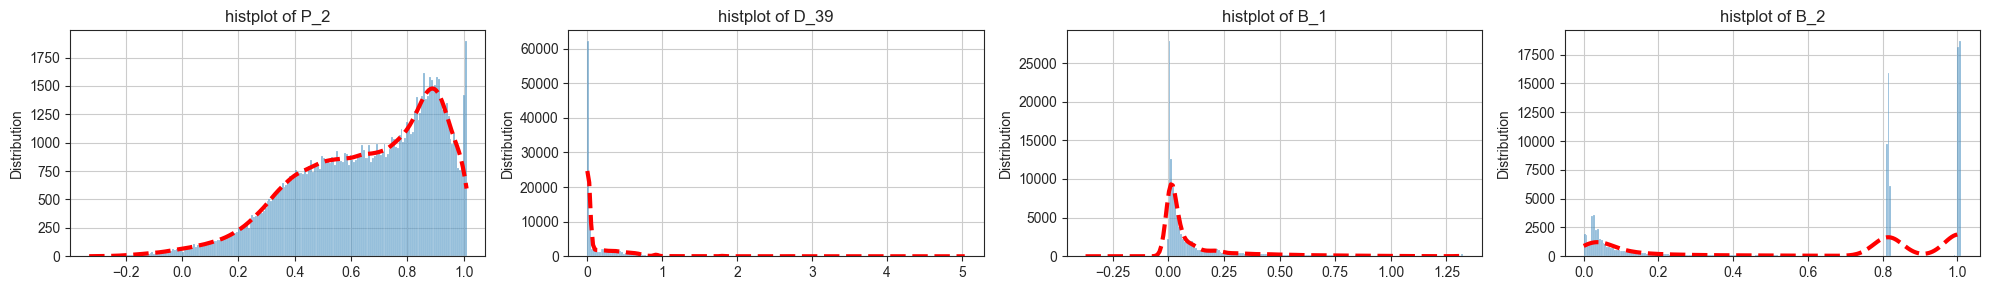

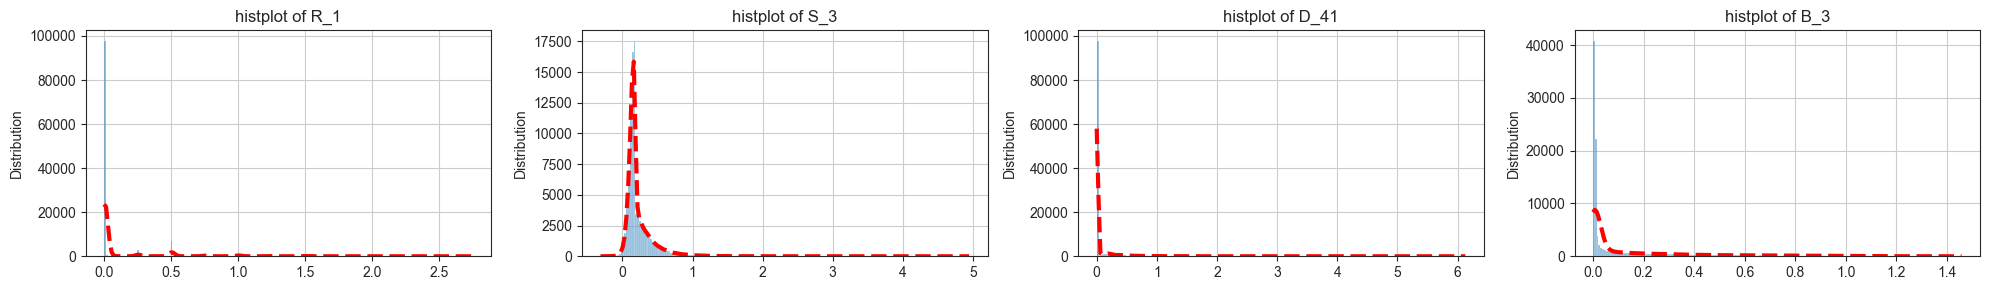

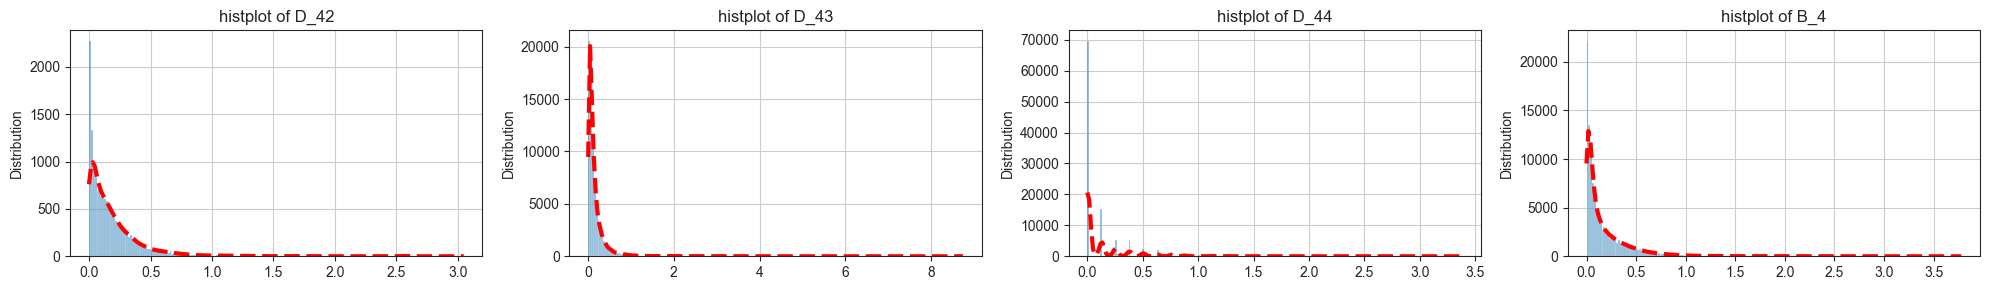

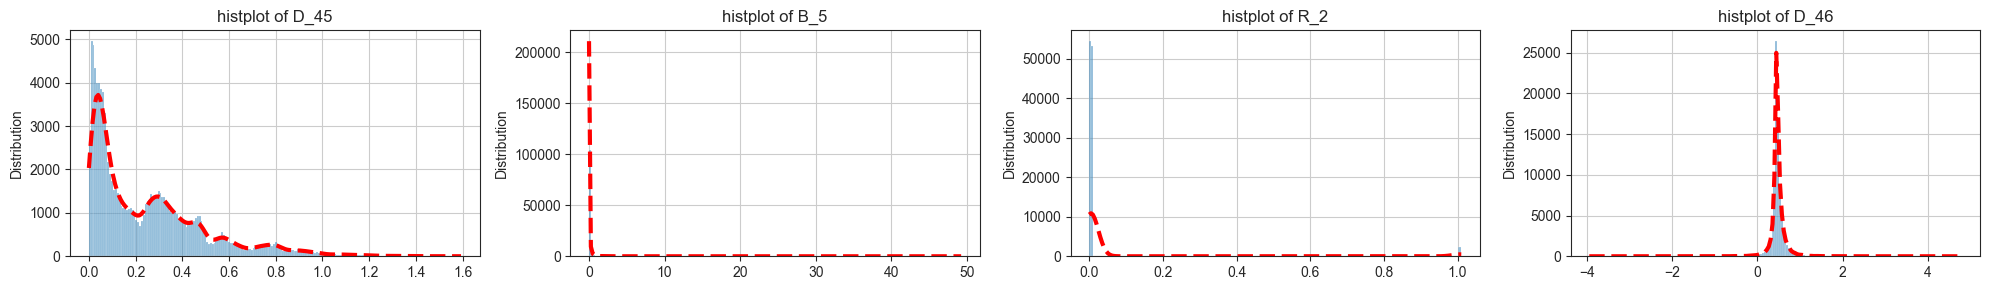

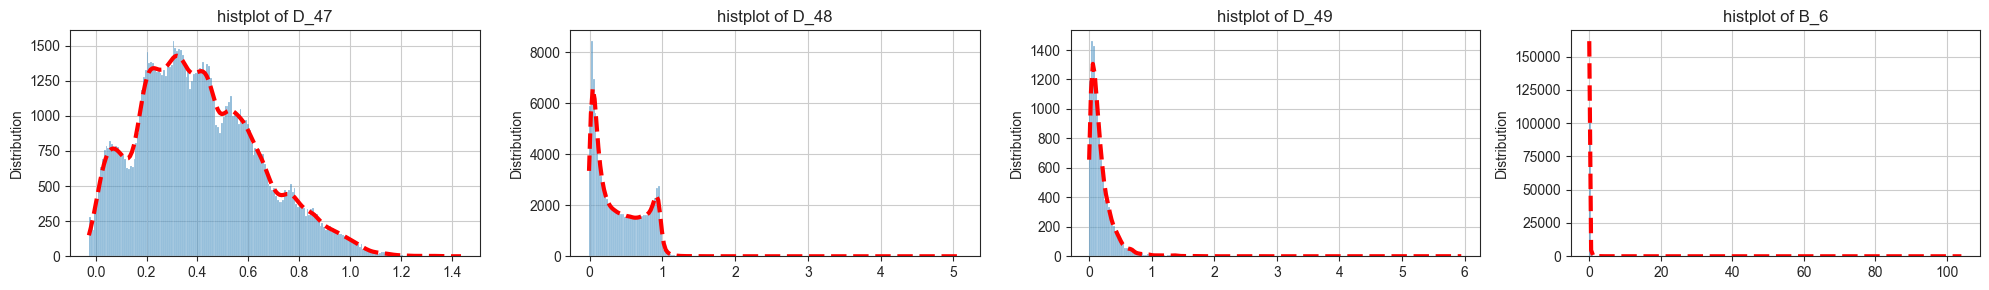

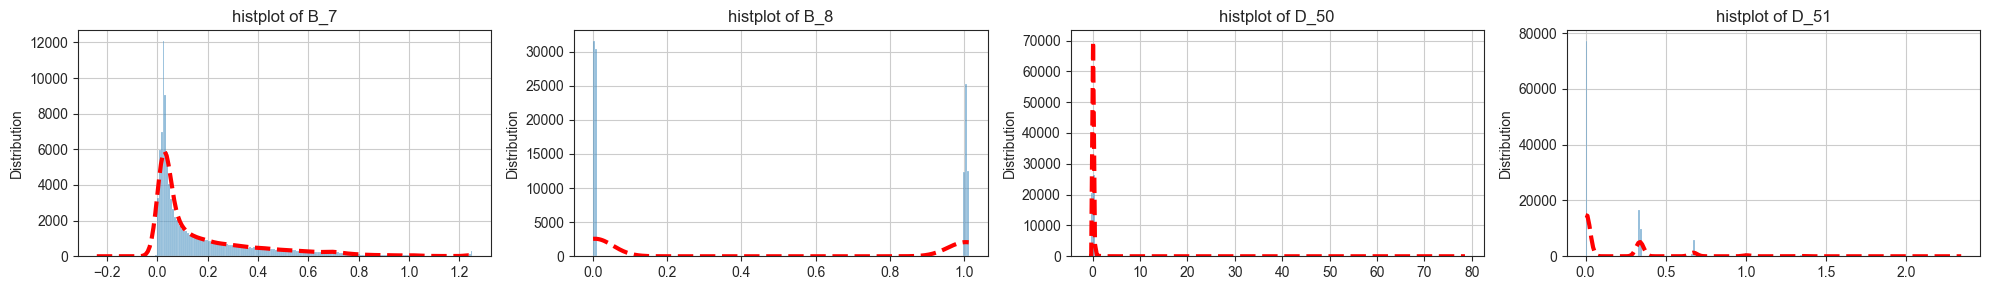

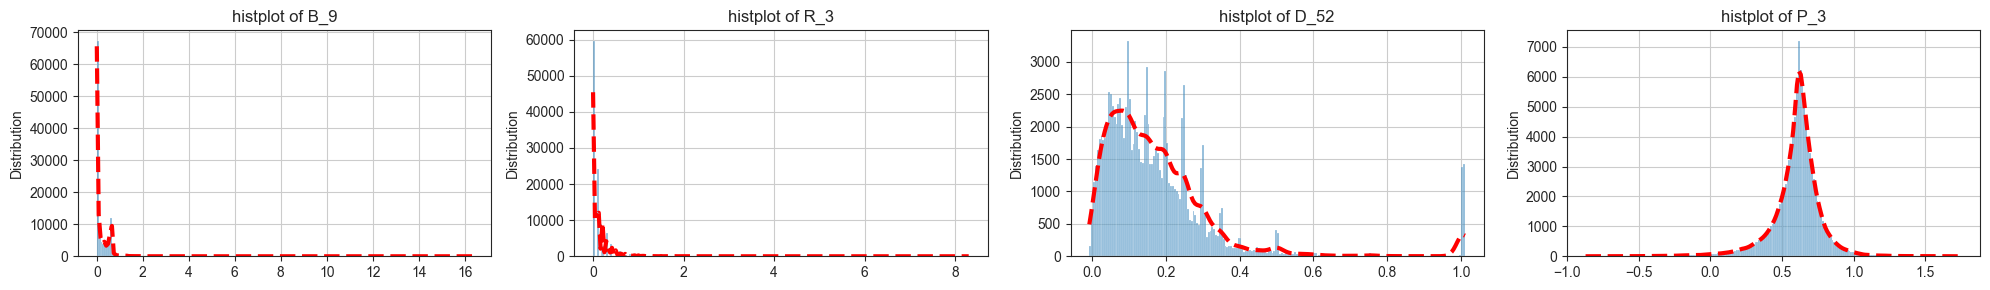

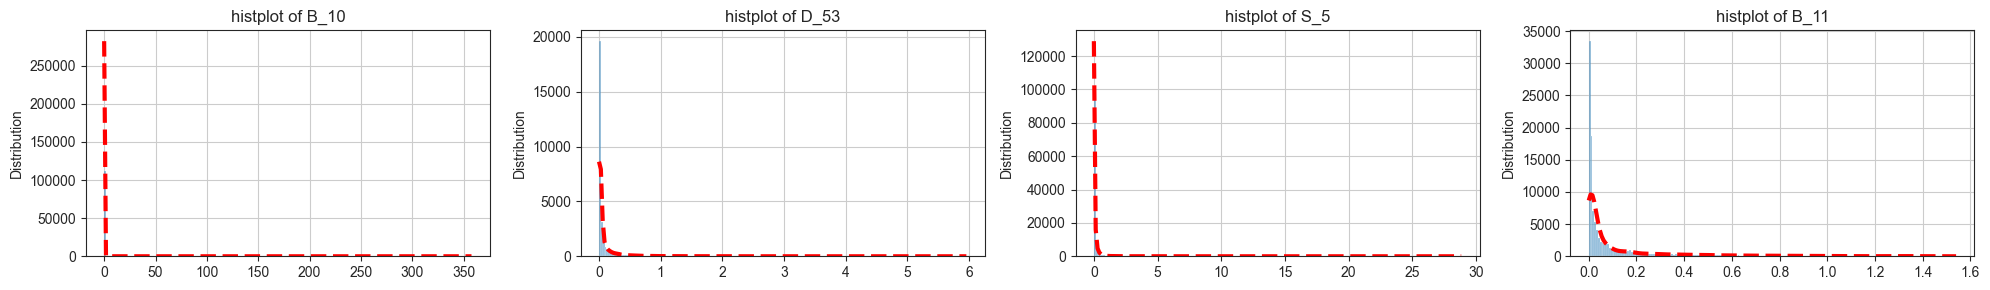

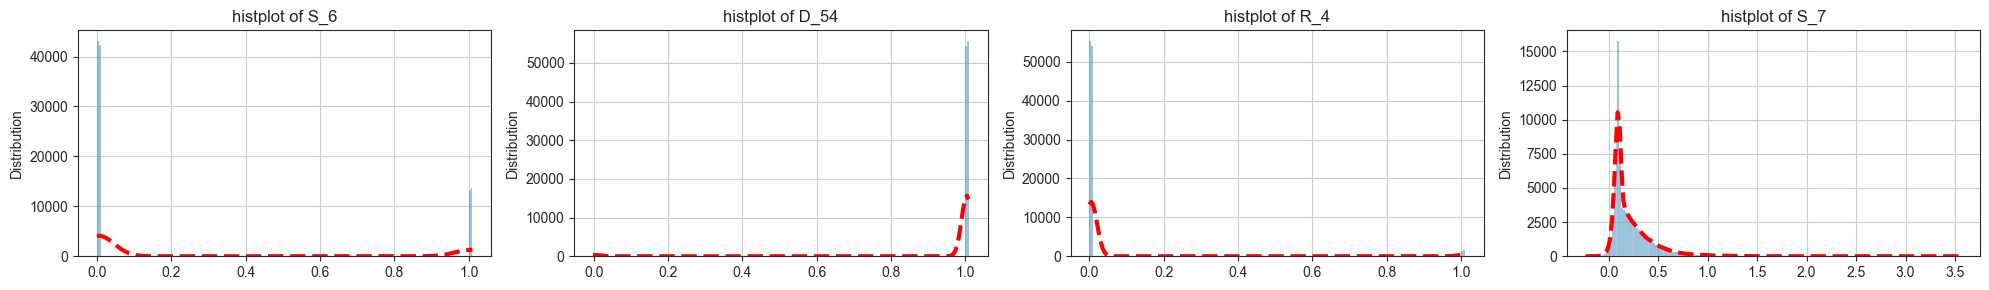

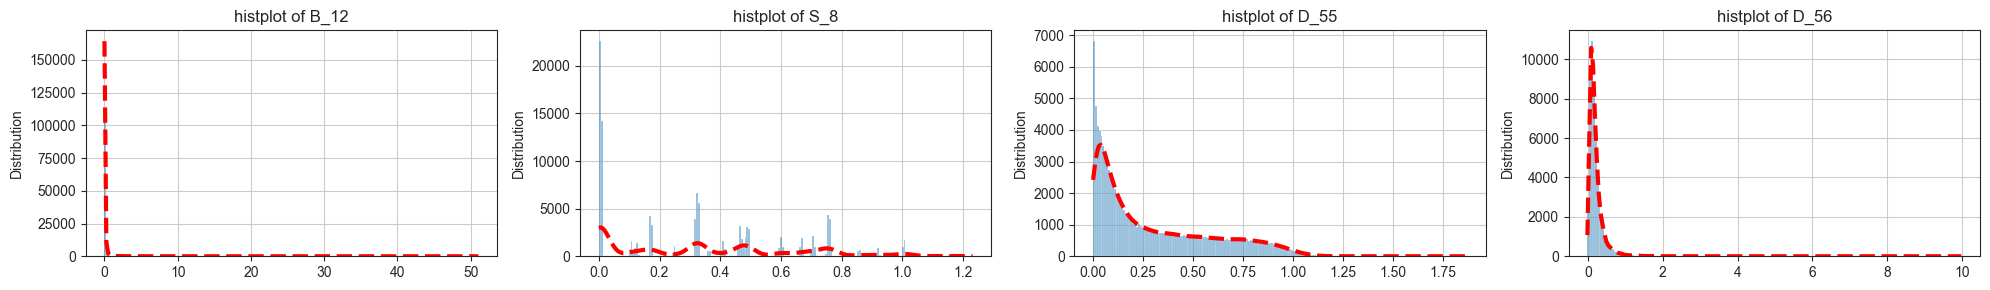

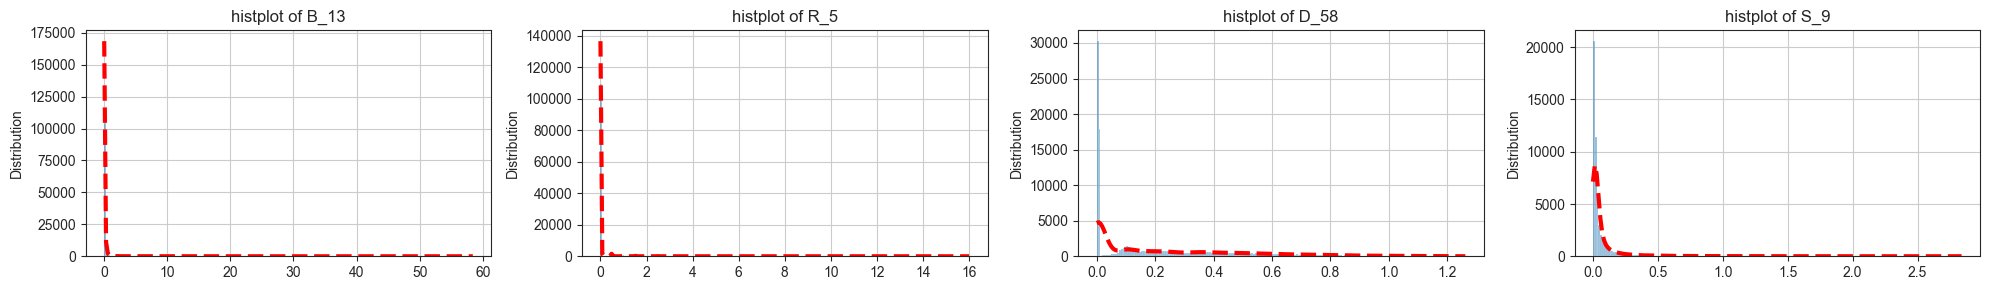

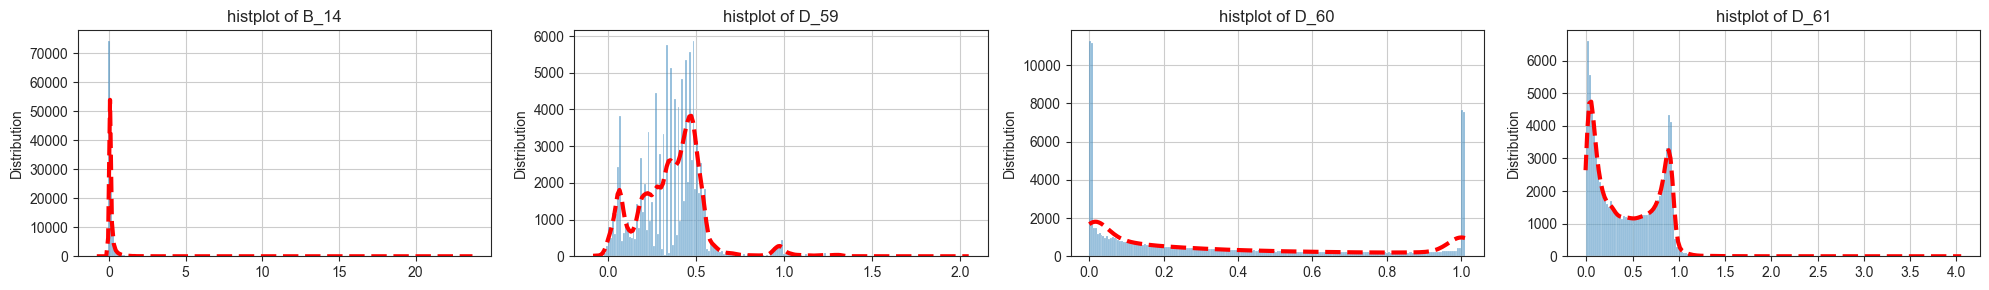

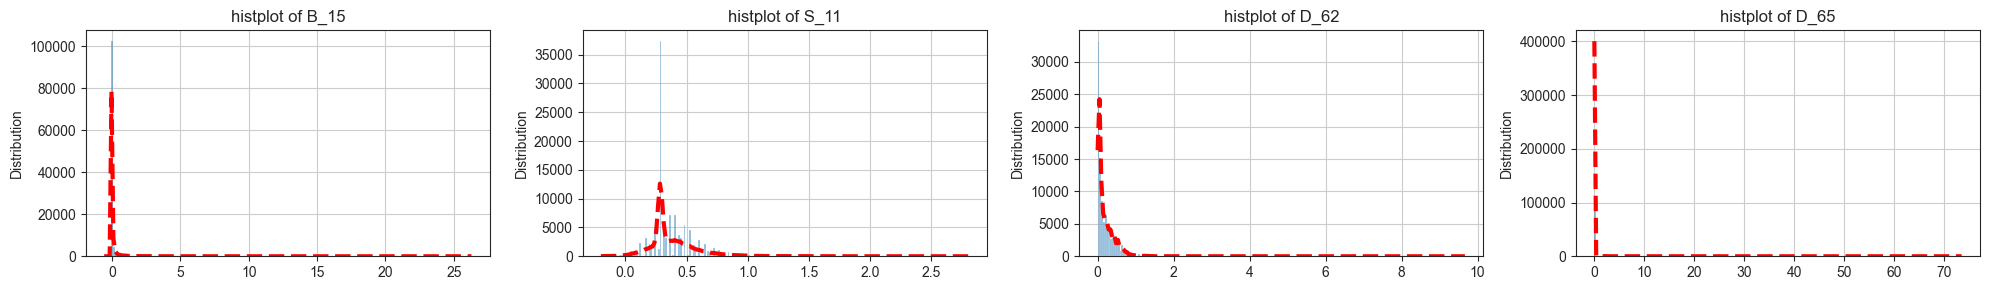

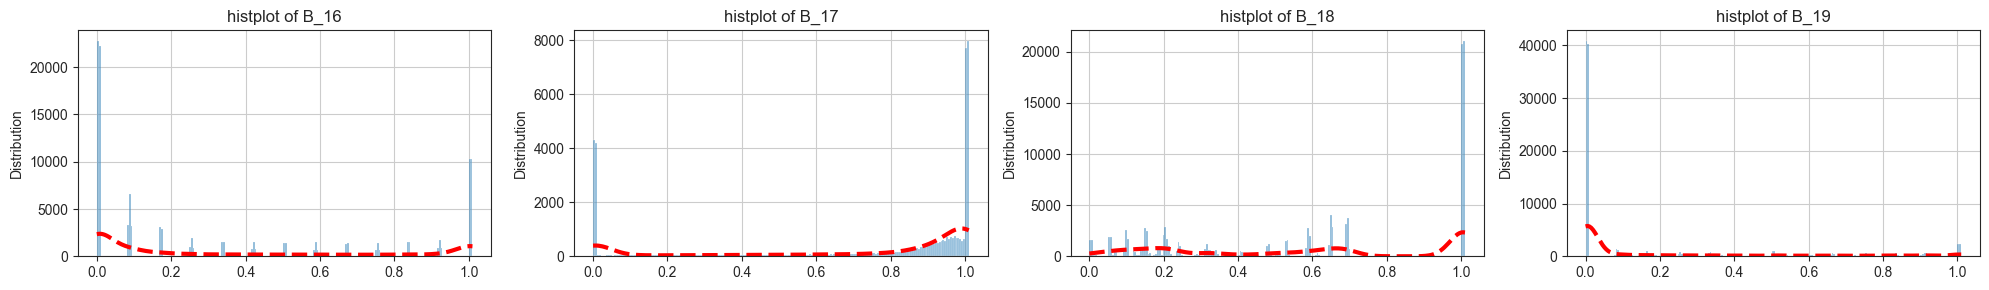

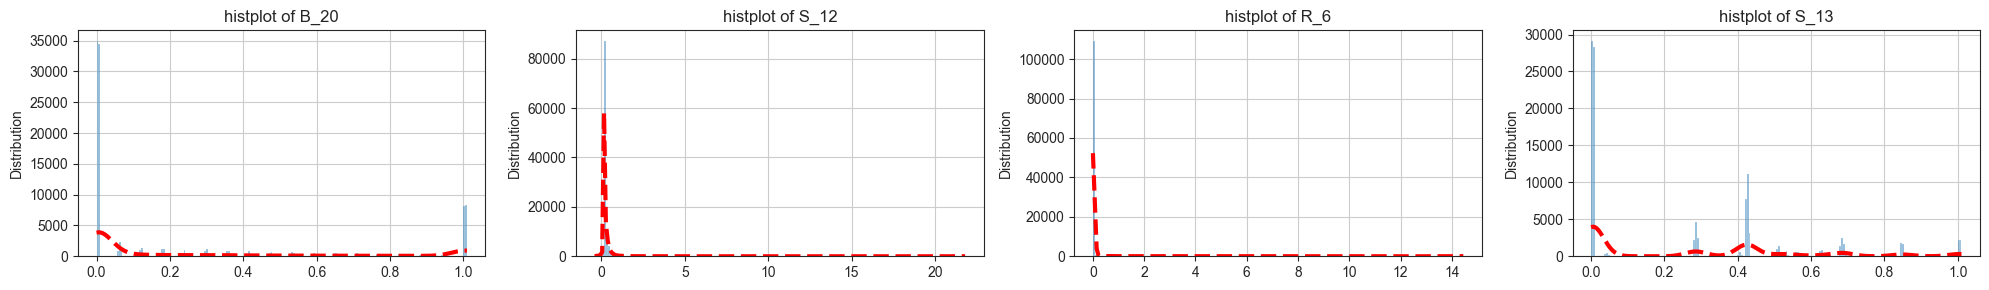

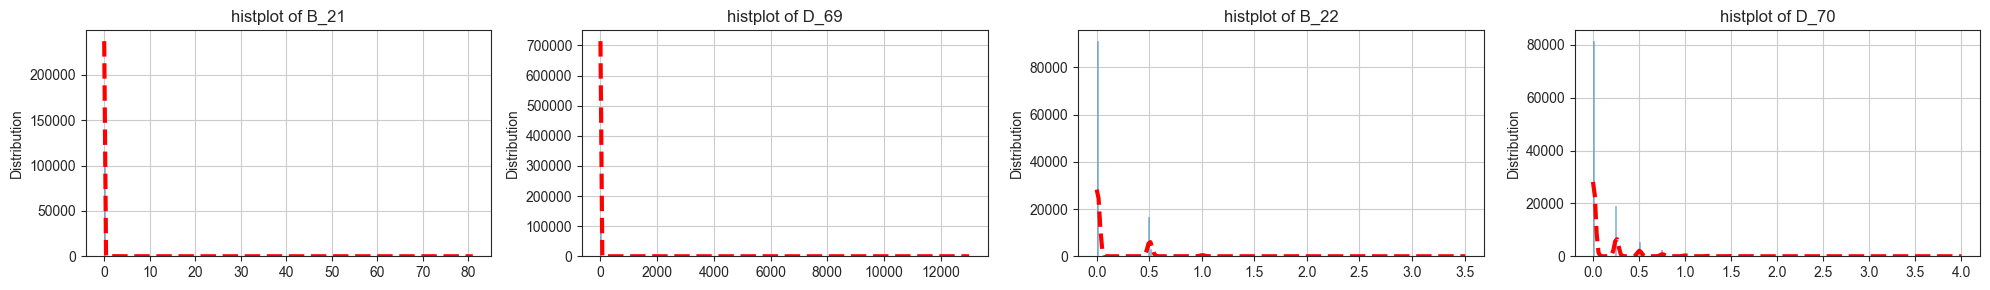

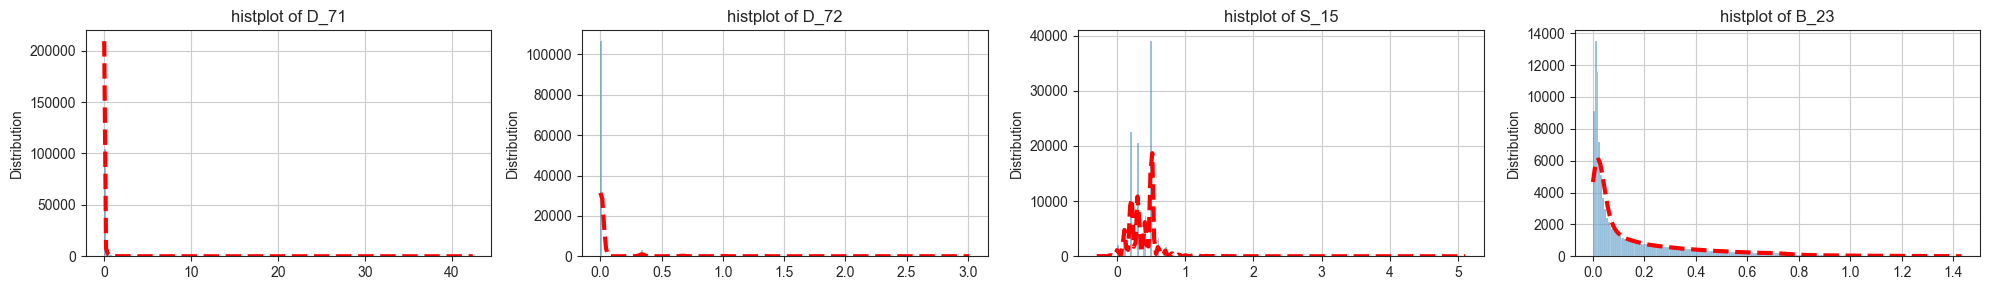

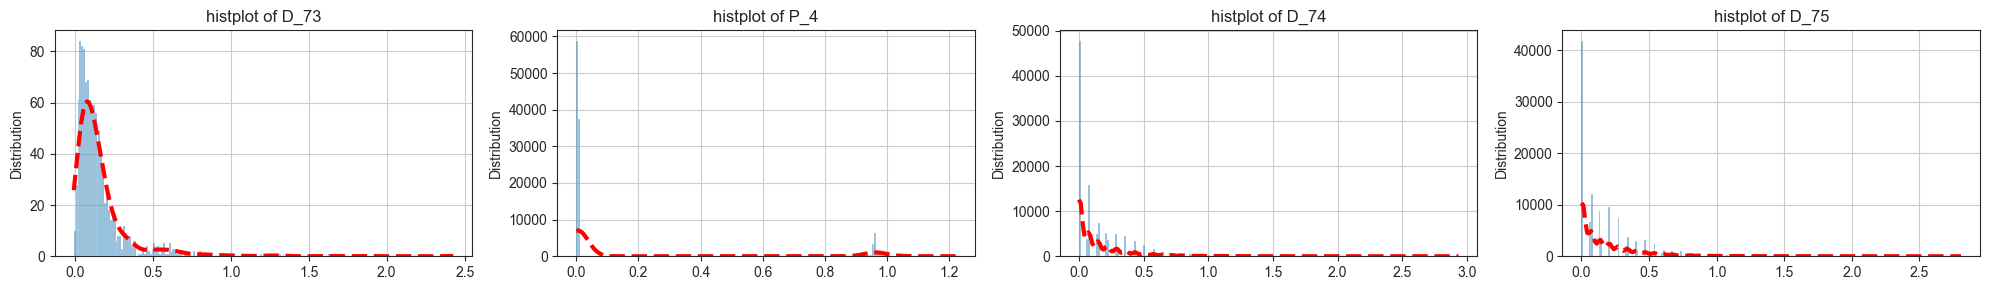

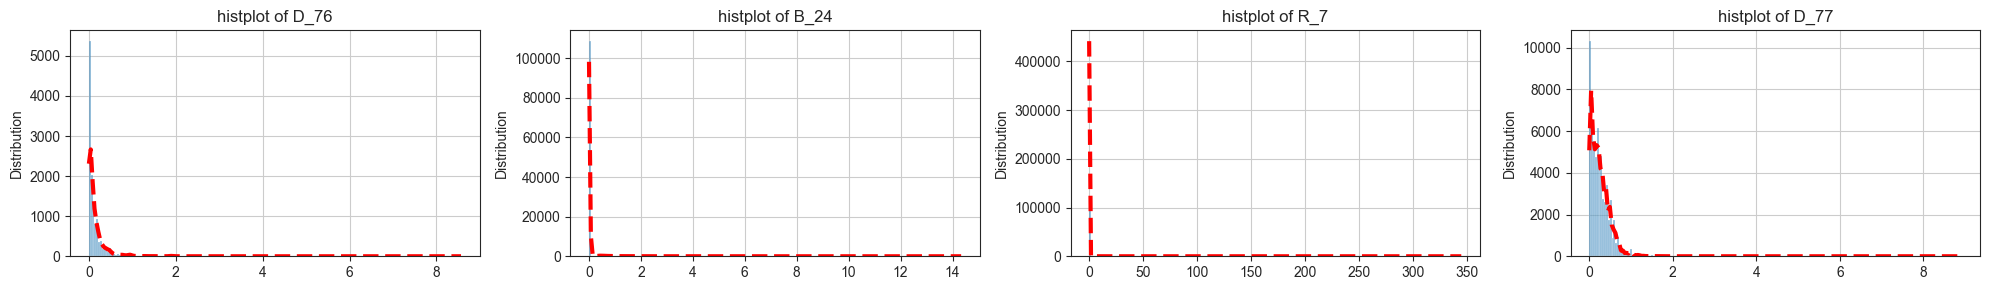

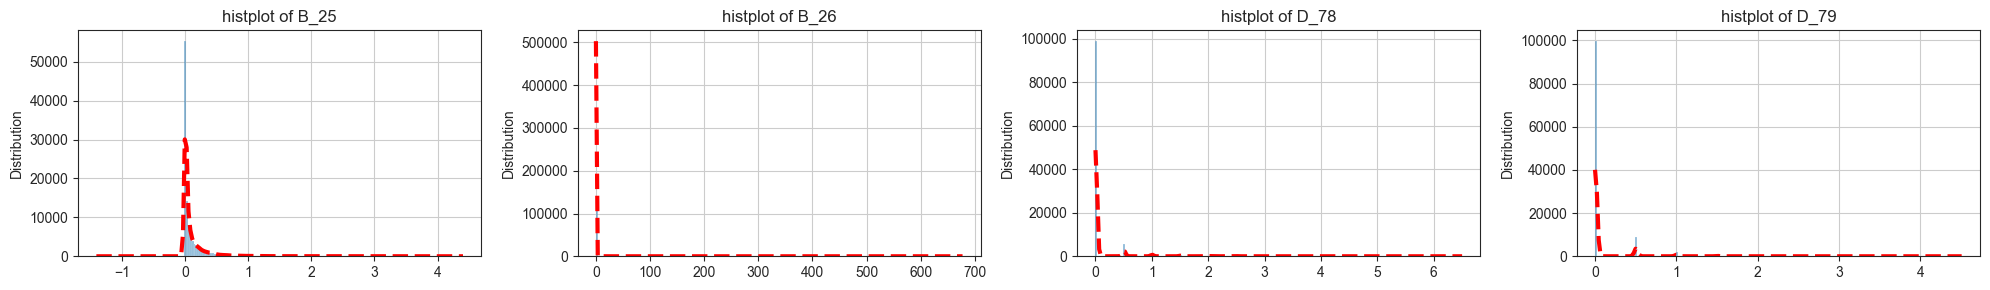

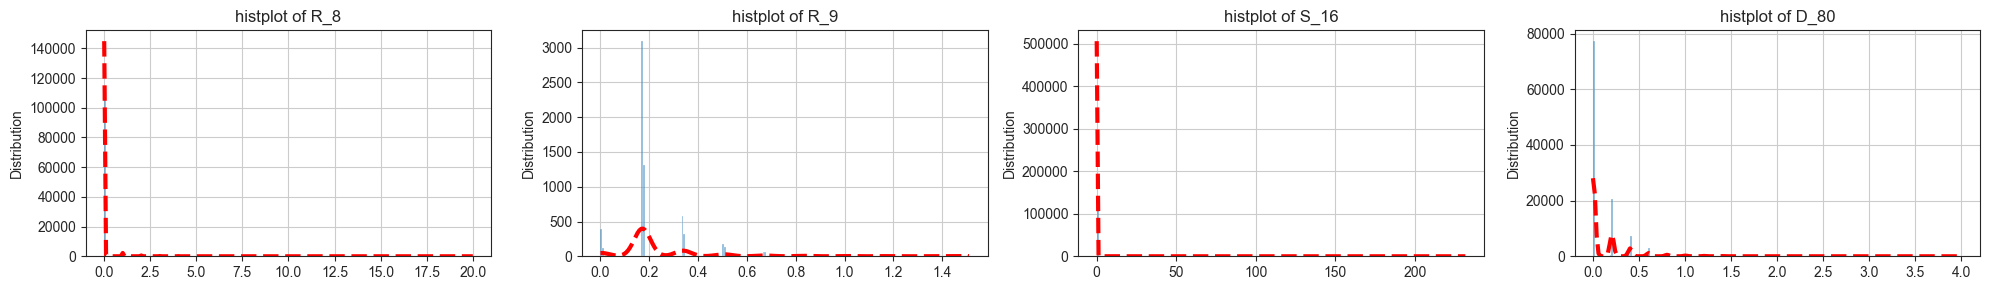

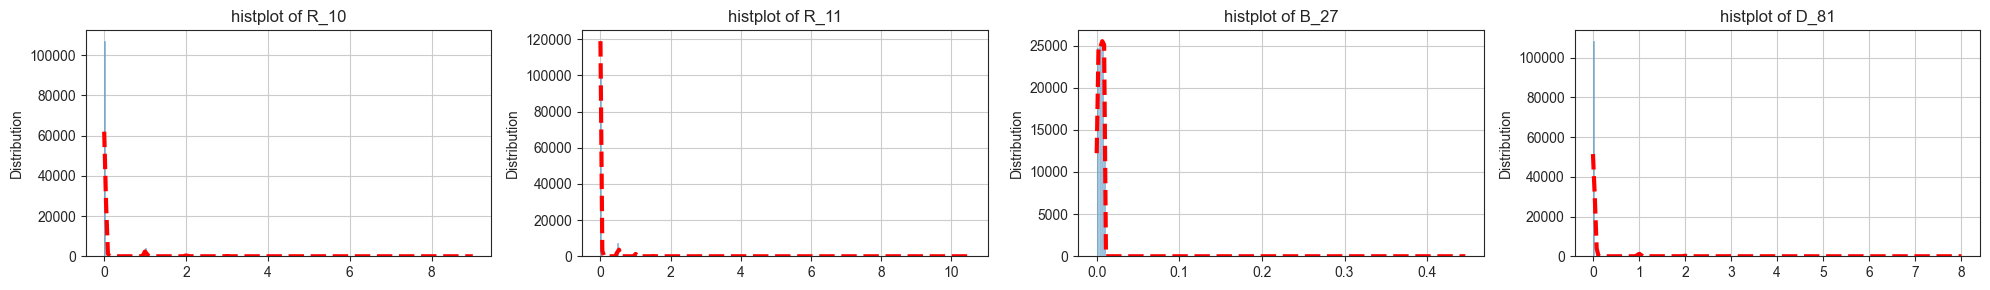

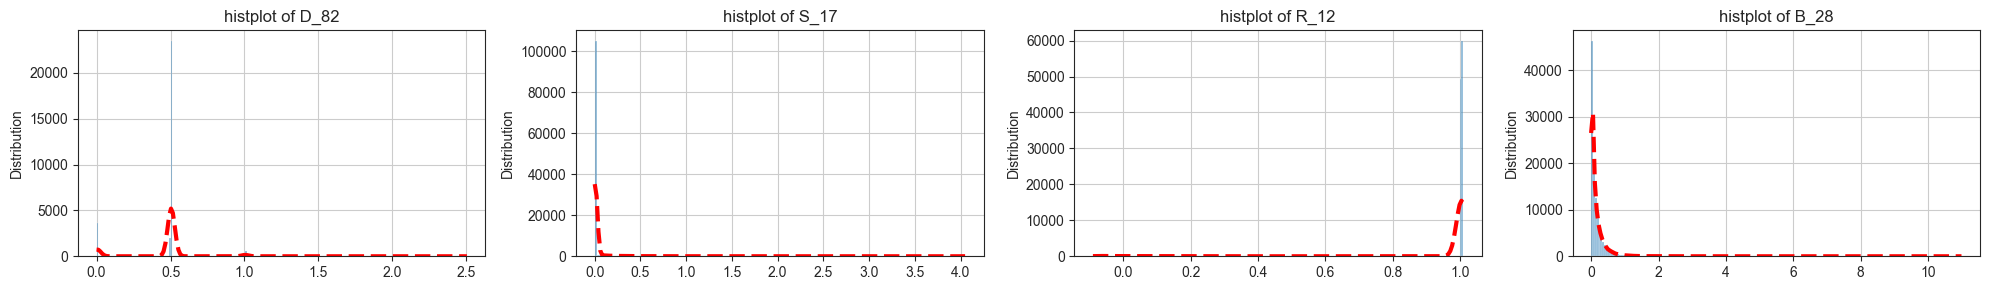

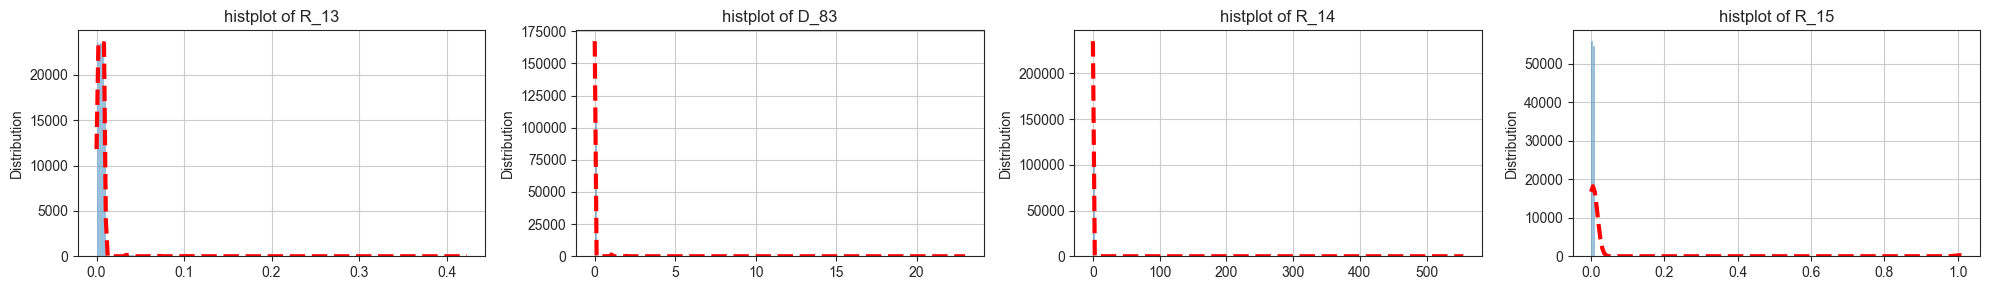

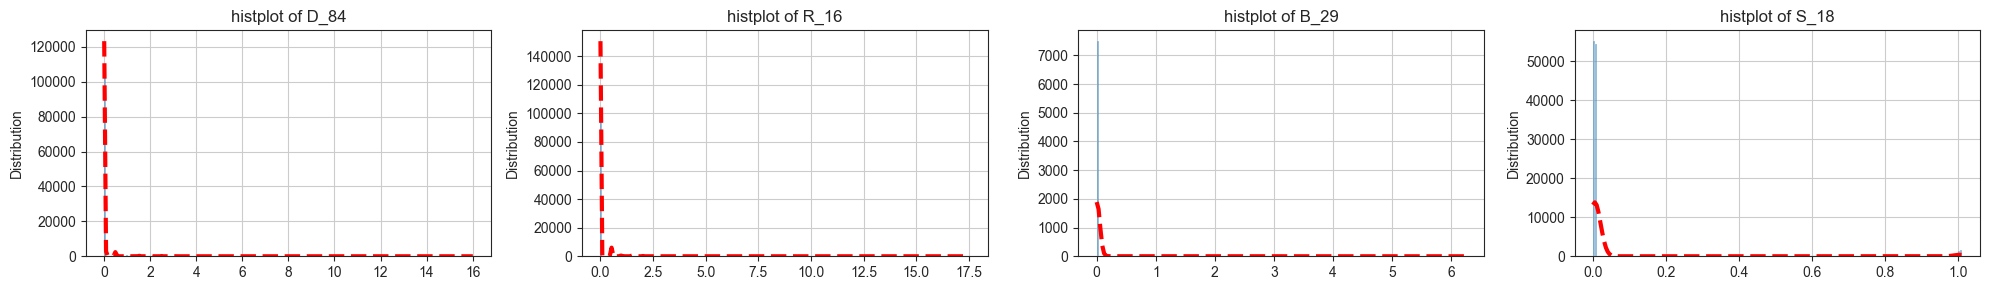

IndexError: list index out of range

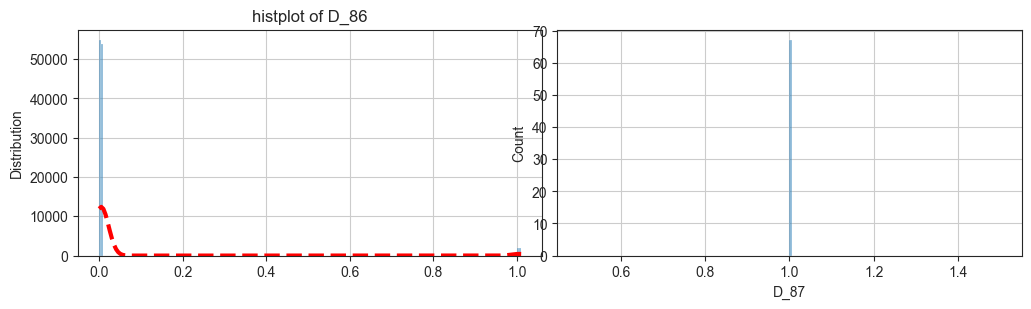

In [265]:
my_plot_grid(train_df,num_cols, 'histplot', bins=200, kde=True)

In [266]:
def plot_graphs(df, features, plot_type):
    # create a figure and axis
    fig, axes = plt.subplots(nrows=int(len(features)/4)+1, ncols=4, figsize=(20, 3*int(len(features)/4)+1))
    
    # unpacking the axes array
    axe = axes.ravel()

    # assigning the features to the subplots
    for idx, ax in enumerate(axe):   
        if idx < len(features):
            if plot_type == 'histplot':
               sns.histplot(df[features[idx]],kde=True, ax=ax, line_kws={'lw':3,'ls':'--','color':'r'})
            #    p.lines[0].set_color('r')
            elif plot_type == 'boxplot':
                sns.boxplot(x=df[features[idx]], orient='v', color='lightblue',notch=True, showcaps=False,
                        flierprops={"marker": "x"},
                        boxprops={"facecolor": (.4, .6, .8, .5)},
                        medianprops={"color": "coral"}, ax=ax)
            ax.set_title(plot_type + ' of ' + features[idx])
        else:
            ax.set_visible(False)
        ax.set_xlabel('')
        ax.set_ylabel('Distribution')
    plt.tight_layout()
    plt.show()
    

In [ ]:
plot_graphs(train_df,num_cols, "histplot")

In [246]:
# change the type of the categorical features
train_df[num_cols].info(max_cols=178, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 112358 entries, c044d0bbe6656fa585004e111997543b5236727706b08892140bdcd47fe76be2 to fea45a6114dd54f3458614f0417cb08e9c8e8a668a1195dfc2914f48fc6801b6
Data columns (total 178 columns):
 #    Column  Non-Null Count   Dtype  
---   ------  --------------   -----  
 0    S_2     112358 non-null  object 
 1    P_2     111439 non-null  float64
 2    D_39    112358 non-null  float64
 3    B_1     112358 non-null  float64
 4    B_2     112316 non-null  float64
 5    R_1     112358 non-null  float64
 6    S_3     91622 non-null   float64
 7    D_41    112316 non-null  float64
 8    B_3     112316 non-null  float64
 9    D_42    16150 non-null   float64
 10   D_43    78718 non-null   float64
 11   D_44    106849 non-null  float64
 12   B_4     112358 non-null  float64
 13   D_45    112316 non-null  float64
 14   B_5     112358 non-null  float64
 15   R_2     112358 non-null  float64
 16   D_46    87670 non-null   float64
 17   D_47    112358 non-null  

### Aggregated profile features

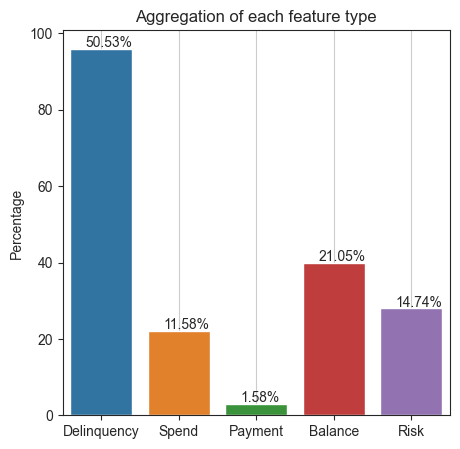

In [238]:
Delinquency = [d for d in train_df.columns if d.startswith('D_')]
Spend = [s for s in train_df.columns if s.startswith('S_')]
Payment = [p for p in train_df.columns if p.startswith('P_')]
Balance = [b for b in train_df.columns if b.startswith('B_')]
Risk = [r for r in train_df.columns if r.startswith('R_')]
Dict = {'Delinquency': len(Delinquency), 'Spend': len(Spend), 'Payment': len(Payment), 'Balance': len(Balance), 'Risk': len(Risk),}

plt.figure(figsize=(5,5))
ax = sns.barplot(x=list(Dict.keys()), y=list(Dict.values()))
for p in ax.patches:
    ax.annotate(f'{p.get_height()/len(train_df.columns)*100:.2f}%', (p.get_x()+0.2, p.get_height()+0.5))
plt.ylabel('Percentage')
plt.grid()
plt.title('Aggregation of each feature type')
plt.show()

In [240]:
del Delinquency, Spend, Payment, Balance, Risk, Dict, ax, p, 
gc.collect()

90390

#### Boxplots

In [249]:
# remove S_2 from num_cols
num_cols.remove('S_2')

In [ ]:
my_plot_grid(train_df, num_cols, 'boxplot')

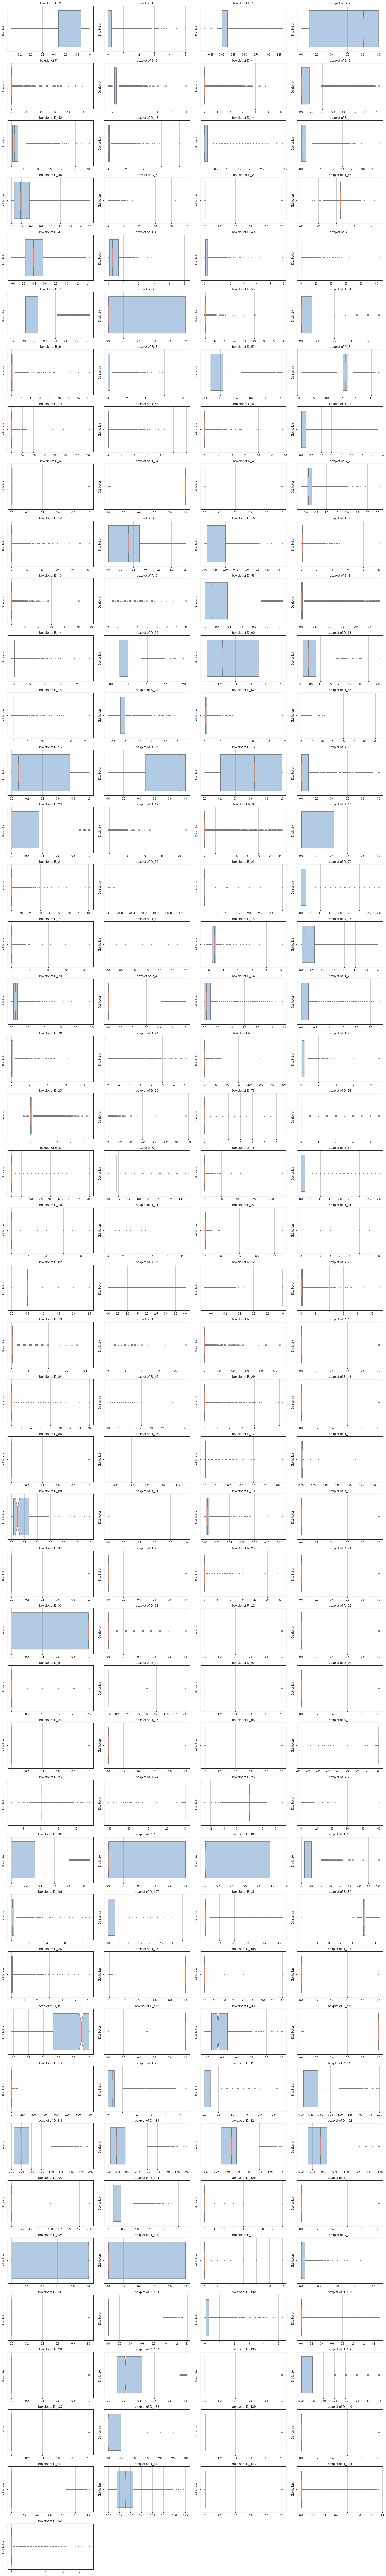

In [251]:
plot_graphs(train_df, num_cols, 'boxplot')

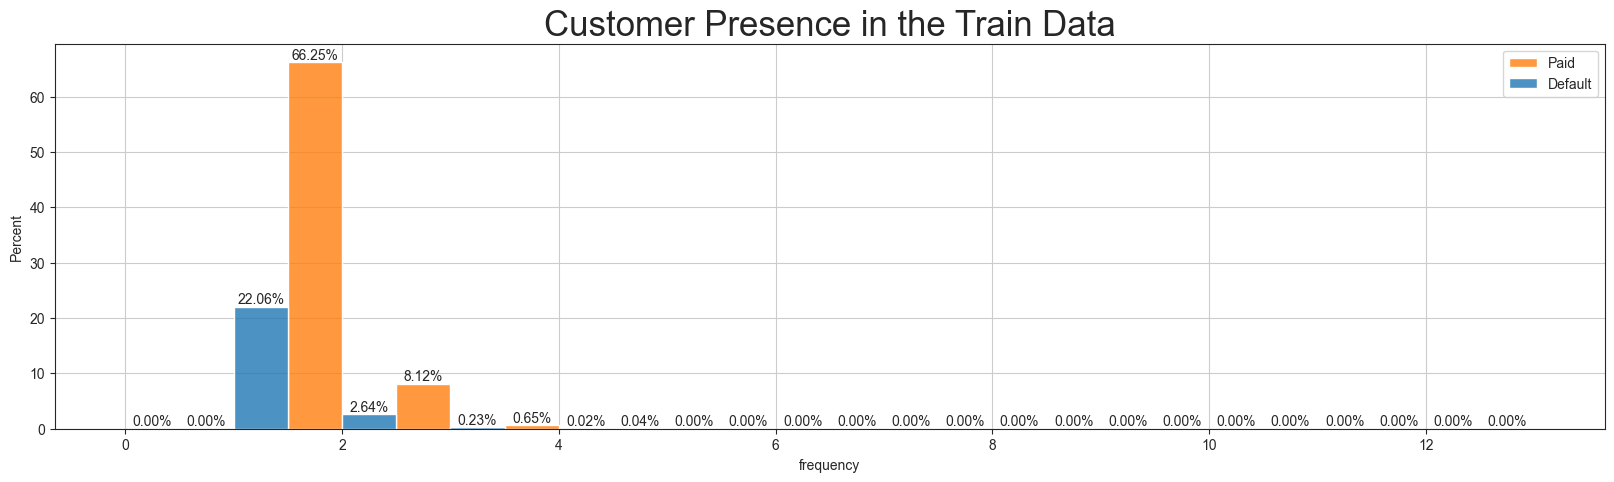

In [313]:
#number of unique customers and their presence in sample data
fig, ax = plt.subplots(1,1, figsize=(20,5))
temp = train_df.groupby(['customer_ID', 'target']).size().reset_index().rename(columns={0:'frequency'})
sns.histplot(x='frequency',hue='target',hue_order=[1,0], stat='percent', bins=np.arange(0,14), data=temp, ax=ax, multiple='dodge',alpha = 0.8)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
ax.set_title('Customer Presence in the Train Data', fontsize = 25)
ax.legend(loc=0, labels=['Paid','Default'])
plt.show()

del temp
_ = gc.collect()

- Remarks:
Most Customers have 1 to 2 card statements

### Missing values

- Removing the columns with more than 80% missing values

In [295]:
# Columns with more than 80% missing values
missing_cols = [col for col in train_df.columns if train_df[col].isnull().sum() > 0.8*len(train_df)]
missing_cols , len(missing_cols)

(['D_42',
  'D_49',
  'D_66',
  'D_73',
  'D_76',
  'R_9',
  'B_29',
  'D_87',
  'D_88',
  'D_106',
  'R_26',
  'D_108',
  'D_110',
  'D_111',
  'B_39',
  'B_42',
  'D_132',
  'D_134',
  'D_135',
  'D_136',
  'D_137',
  'D_138',
  'D_142'],
 23)

In [296]:
gc.collect()

570

- Dropping columns with more than 80% missing values

In [297]:
missing_cols.append('S_2')
train_df.drop(missing_cols, axis=1, inplace=True)
train_df.shape

(112358, 166)

- Fill missing values with the median of the column

In [298]:
new_categorical_cols = [i for i in categorical_cols if i not in missing_cols]
new_categorical_cols , len(new_categorical_cols)

(['B_30',
  'B_38',
  'D_114',
  'D_116',
  'D_117',
  'D_120',
  'D_126',
  'D_63',
  'D_64',
  'D_68'],
 10)

In [285]:
train_df[new_categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 112358 entries, c044d0bbe6656fa585004e111997543b5236727706b08892140bdcd47fe76be2 to fea45a6114dd54f3458614f0417cb08e9c8e8a668a1195dfc2914f48fc6801b6
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   B_30    112316 non-null  float64
 1   B_38    112316 non-null  float64
 2   D_114   108786 non-null  float64
 3   D_116   108786 non-null  float64
 4   D_117   108786 non-null  float64
 5   D_120   108786 non-null  float64
 6   D_126   110011 non-null  float64
 7   D_63    112358 non-null  object 
 8   D_64    107966 non-null  object 
 9   D_68    107972 non-null  float64
dtypes: float64(8), object(2)
memory usage: 13.5+ MB


In [286]:
new_num_cols = [i for i in num_cols if i not in missing_cols]
new_num_cols , len(new_num_cols)

(['P_2',
  'D_39',
  'B_1',
  'B_2',
  'R_1',
  'S_3',
  'D_41',
  'B_3',
  'D_43',
  'D_44',
  'B_4',
  'D_45',
  'B_5',
  'R_2',
  'D_46',
  'D_47',
  'D_48',
  'B_6',
  'B_7',
  'B_8',
  'D_50',
  'D_51',
  'B_9',
  'R_3',
  'D_52',
  'P_3',
  'B_10',
  'D_53',
  'S_5',
  'B_11',
  'S_6',
  'D_54',
  'R_4',
  'S_7',
  'B_12',
  'S_8',
  'D_55',
  'D_56',
  'B_13',
  'R_5',
  'D_58',
  'S_9',
  'B_14',
  'D_59',
  'D_60',
  'D_61',
  'B_15',
  'S_11',
  'D_62',
  'D_65',
  'B_16',
  'B_17',
  'B_18',
  'B_19',
  'B_20',
  'S_12',
  'R_6',
  'S_13',
  'B_21',
  'D_69',
  'B_22',
  'D_70',
  'D_71',
  'D_72',
  'S_15',
  'B_23',
  'P_4',
  'D_74',
  'D_75',
  'B_24',
  'R_7',
  'D_77',
  'B_25',
  'B_26',
  'D_78',
  'D_79',
  'R_8',
  'S_16',
  'D_80',
  'R_10',
  'R_11',
  'B_27',
  'D_81',
  'D_82',
  'S_17',
  'R_12',
  'B_28',
  'R_13',
  'D_83',
  'R_14',
  'R_15',
  'D_84',
  'R_16',
  'S_18',
  'D_86',
  'R_17',
  'R_18',
  'B_31',
  'S_19',
  'R_19',
  'B_32',
  'S_20',
  'R_2

In [287]:
train_df[new_num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 112358 entries, c044d0bbe6656fa585004e111997543b5236727706b08892140bdcd47fe76be2 to fea45a6114dd54f3458614f0417cb08e9c8e8a668a1195dfc2914f48fc6801b6
Columns: 155 entries, P_2 to D_145
dtypes: float64(154), int64(1)
memory usage: 137.8+ MB


In [291]:
# Function for filling missing values of numerical features with median and categorical features with mode
def fill_missing_values(df, categorical_cols, num_cols):
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    yield df

In [301]:
train_df = fill_missing_values(train_df, new_categorical_cols, new_num_cols)
train_df.isnull().sum().any()

False

# Feature Engineering

- Co-relation between features

In [302]:
def correlation_check(df, threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

In [309]:
correlation_check(train_df, 0.8) , len(correlation_check(train_df, 0.8))

(['B_11',
  'S_7',
  'D_55',
  'B_13',
  'D_61',
  'B_15',
  'B_18',
  'B_20',
  'B_23',
  'D_74',
  'D_75',
  'D_77',
  'R_8',
  'B_33',
  'S_24',
  'D_104',
  'D_107',
  'B_37',
  'D_118',
  'D_119',
  'D_131',
  'D_141',
  'D_143'],
 23)

In [308]:
train_df_corr = train_df.corr().abs()
dropouts = []
pair = []

for col in train_df_corr.columns:
    for i in range(len(train_df_corr)):
        if abs(train_df_corr[col].iloc[i]) >=0.8 and col != train_df_corr.columns[i]:
            print(f"{col} and {train_df_corr.columns[i]} are highly co-related")
            if col not in pair:
                pair.append(col)
                pair.append(train_df_corr.columns[i])
                dropouts.append(train_df_corr.columns[i])
print(f"Dropping Columns : {dropouts} , {len(dropouts)}")

B_1 and B_11 are highly co-related
B_1 and B_37 are highly co-related
B_2 and B_18 are highly co-related
B_2 and B_33 are highly co-related
S_3 and S_7 are highly co-related
D_48 and D_55 are highly co-related
D_48 and D_61 are highly co-related
B_7 and B_23 are highly co-related
B_11 and B_1 are highly co-related
B_11 and B_37 are highly co-related
S_7 and S_3 are highly co-related
B_12 and B_13 are highly co-related
D_55 and D_48 are highly co-related
B_13 and B_12 are highly co-related
R_5 and R_8 are highly co-related
D_58 and D_74 are highly co-related
D_58 and D_75 are highly co-related
B_14 and B_15 are highly co-related
D_61 and D_48 are highly co-related
B_15 and B_14 are highly co-related
D_62 and D_77 are highly co-related
B_16 and B_20 are highly co-related
B_18 and B_2 are highly co-related
B_18 and B_33 are highly co-related
B_20 and B_16 are highly co-related
B_23 and B_7 are highly co-related
D_74 and D_58 are highly co-related
D_74 and D_75 are highly co-related
D_75 a

In [310]:
del train_df_corr
_ = gc.collect()

- Chi2 test for feature selection

- The Chi-Square test of independence is used to determine if there is a significant relationship between two categorical (nominal) variables. 
- It means the Chi-Square Test of Independence is a hypothesis testing test with 2 hypotheses present; the Null Hypothesis and the Alternative Hypothesis. 
- The hypothesis is written below.
    - Null Hypothesis (H0): There is no relationship between the variables
    - Alternative Hypothesis (H1): There is a relationship between variables
    
- Just like any statistical testing, 
     - Lets we choose our p-value = 0.05 : Choose a significance level (e.g. SL = 0.05 with a 95% confidence).
    - if p-value test result is more than 0.05 , it means that test result will lie in acceptance region and we will accept the null hypothesis
    - if p-value test result is less than 0.05 , it means that test result will lie in rejection(critical) region and we will reject the null hypothesis and will accept the alternate hypothesis.
    

In [316]:
from sklearn.preprocessing import OrdinalEncoder

def encoding(df, categorical_cols):
    encoder = OrdinalEncoder()
    df[categorical_cols] = encoder.fit_transform(df[categorical_cols])
    return df


In [317]:
from sklearn.feature_selection import chi2

def chi2_check(df, categorical_cols, target, threshold):
    df = encoding(df, categorical_cols)
    chi2_scores = chi2(df[categorical_cols], df[target])[0]
    p_values = chi2(df[categorical_cols], df[target])[1]
    p_values = pd.Series(p_values, index=categorical_cols)
    p_values.sort_values(ascending=False, inplace=True)
    p_values.plot.bar()
    plt.show()
    return p_values[p_values > threshold].index

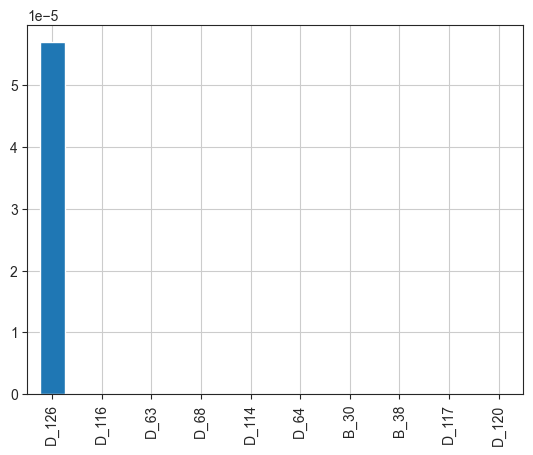

Index([], dtype='object')

In [318]:
chi2_check(train_df, new_categorical_cols, 'target', 0.05)

- Using SelectKBest to select the best features

In [329]:
from sklearn.feature_selection import SelectKBest
chc = SelectKBest(score_func=chi2, k=7)
X = pd.get_dummies(train_df[new_categorical_cols])
y = train_df['target']
chc.fit(X, y)
temp_df = pd.DataFrame({"Score":chc.scores_,"P_Value":np.round(chc.pvalues_,5)},index=X.columns)
temp_df.nlargest(10, 'Score')

,Score,P_Value
B_38,24801.424759,0.00000
B_30,13475.267191,0.00000
D_120,3484.058383,0.00000
D_117,3037.703029,0.00000
D_64,1342.525343,0.00000
D_114,1185.991178,0.00000
D_68,1028.390296,0.00000
D_63,160.300431,0.00000
D_116,101.038300,0.00000
D_126,16.201792,0.00006


 - all categorical features are having p-value in acceptance region, so we will reject the null hypothesis and will accept the alternate hypothesis.

In [350]:
cols = cols = [i for i in train_df.columns.to_list()]
len(cols)

166

In [353]:
from scipy.stats import chi2_contingency
def chi2_contingency_check(df, categorical_var, target, threshold):
    """
    H0: Categorical variables are not correlated
    H1: Categorical variables are highly correlated
    """
    dropouts = []
    for col in categorical_var:
        chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[col], df[target]))
        if p <= threshold:
            print(f"{col} is highly correlated with target variable")
        else:
            print(f"{col} is not correlated with target variable")
            dropouts.append(col)
    return dropouts

In [354]:
chi2_contingency_check(train_df, new_categorical_cols, 'target', 0.05)

B_30 is highly correlated with target variable
B_38 is highly correlated with target variable
D_114 is highly correlated with target variable
D_116 is highly correlated with target variable
D_117 is highly correlated with target variable
D_120 is highly correlated with target variable
D_126 is highly correlated with target variable
D_63 is highly correlated with target variable
D_64 is highly correlated with target variable
D_68 is highly correlated with target variable


[]

In [355]:
# del ax,chc, feature_score_df, i, temp_df, X, y
gc.collect()

7

Note : If we have multiple classes within a category, we would not be able to easily tell which class of the features are responsible for the relationship if the Chi-square table is larger than 2×2. 
- Comparing multiple classes of feature against each other would means that the error rate of a false positive(Type-1) compund with each test. 
- For example, if we choose our first test at p-value level 0.05 means there is a 5% chance of a false positive; if we have multiple classes, the test after that would compounding the error with the chance become 10% of a false positive, and so forth. With each subsequent test, the error rate would increase by 5%. In our case above, we had 3 pairwise comparisons. This means that our Chi-square test would have an error rate of 15%. Meaning our p-value being tested at would equal 0.15, which is quite high.
- In this case, we could use the Bonferroni-adjusted method for correcting the p-value we use. We adjust our P-value by the number of pairwise comparisons we want to do. The formula is p/N, where p= the p-value of the original test and N= the number of planned pairwise comparisons. For example, in our case, above we have 3 class within the Property_Area feature; which means we would have 3 pairwise comparisons if we test all the class against the Loan_Status feature. Our P-value would be 0.05/3 = 0.0167
- Using the adjusted P-value, we could test all the previously significant result to see which class are responsible for creating a significant relationship.

```python
# Creating hypothesis using all classes of the columns
chi_result1 = {}
for i in result_chi["Cat_Features"]:
    dummy = pd.get_dummies(df_loan[i])
    ad_p_value = 0.05/df_loan[i].nunique()
    for j in dummy:
        if chi2_contingency(pd.crosstab(df_loan["Loan_Status"],dummy[j]))[1]<ad_p_value:
            chi_result1["{}-{}".format(i,j)] = "Reject the null Hypothesis"
        else :
            chi_result1["{}-{}".format(i,j)] = "Accept the null Hypothesis" 
```

#### Compute the ANOVA F-value for the provided sample.

In [328]:
# Selection using SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif
chc = SelectKBest(score_func=f_classif, k=10)
chc.fit(train_df[new_num_cols], train_df['target'])
feature_score_df = pd.DataFrame({"Score":chc.scores_,"P_Value":np.round(chc.pvalues_,3)},index=train_df[new_num_cols].columns)
feature_score_df.nsmallest(10, 'Score')

,Score,P_Value
D_69,0.009976,0.920
S_12,1.115496,0.291
R_18,2.408670,0.121
D_144,2.883869,0.089
B_27,8.809548,0.003
B_15,8.996407,0.003
S_19,17.301469,0.000
S_18,20.703966,0.000
D_105,20.803992,0.000
S_27,35.449146,0.000


- Remarks 
B_15	8.996407	0.003
S_19	17.301469	0.000
S_18	20.703966	0.000
D_105	20.803992	0.000
S_27	35.449146	0.000

Conclusion:
- The ANOVA F-value scores examine if, when we group the numerical feature by the target, the means for each group are significantly different.
- The higher the F-value, the more significant the difference between the means.
- The p-values for each feature show us the probability of getting the computed ANOVA F-value if the null hypothesis (that the means for each group are the same) is true.
- The lower the p-value, the more likely it is that our computed value would occur if the null hypothesis is true (meaning there is no relationship between the feature and the target).
- We can use these scores to select the top features for modeling.
- Above we can see that the top 5 features are S_19, S_18, D_105, S_27, and S_26 having low p-values and high F-values.

#### Mutual Information

- Mutual information is a measure of dependence or “mutual dependence” between two random variables(x and y).

- The mutual information between two random variables X and Y can be stated formally as follows:

  **I(X ; Y) = H(X) – H(X | Y)**
  
  - Where I(X ; Y) is the mutual information for X and Y, 
  - H(X) is the entropy for X and H(X | Y) is the conditional entropy for X given Y.
  
- Mutual information is a measure of dependence or “mutual dependence” between two random variables. As such, the 
  measure is symmetrical, meaning that I(X ; Y) = I(Y ; X).

In [356]:
# encode the Categorical Variable
# can be used as alternative to encoding function above
from sklearn.preprocessing import LabelEncoder 
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [357]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [359]:
df_temp = MultiColumnLabelEncoder(columns = new_categorical_cols).fit_transform(train_df)
X = df_temp.drop(['target'], axis=1)
y = df_temp['target']
mic = SelectKBest(score_func=mutual_info_classif, k=10)
mic.fit(X, y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns,name='MI_Score')
feature_MI_score.sort_values(ascending=False)

P_2     0.212379
D_48    0.151328
D_75    0.134499
D_61    0.134297
B_9     0.133738
          ...   
B_27    0.000000
S_18    0.000000
R_18    0.000000
R_25    0.000000
D_93    0.000000
Name: MI_Score, Length: 165, dtype: float64

In [362]:
feature_MI_score[feature_MI_score > 0.01]

P_2      0.212379
D_39     0.030132
B_1      0.115795
B_2      0.120335
R_1      0.063636
           ...   
D_127    0.023362
D_128    0.018805
D_130    0.021822
D_131    0.023858
D_133    0.019977
Name: MI_Score, Length: 111, dtype: float64

or directly use fit and transform and get the top k features according to Mutual Score
df_temp_afs=mic.fit_transform(X,y)
##feature_MI_score = pd.Series(mic.scores_,index=X.columns)
##feature_MI_score.sort_values(ascending=False)
df_temp_afs.shape

### Feature Selection using Filter Method
**Filter Method Types**
1. Basic Statistical Filter Methods
    - VarianceThreshod (Remove the Constant Feature and Quasi-Constant Features)
    - Remove Duplicate Features

#### Variance Threshold
**Removing Numerical features with low variance**

- We simply compute the variance of each features, and we select the subset of features based on a user-specified threshold.
- We assume that features with a higher variance may contain more useful information.
- **This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.**
- As we are not taking the relationship between features variables or feature and target variables into account, which is one of the drawbacks of Variance Threshold filter method.
- It is applicable only on Numerical features.

In [363]:
from sklearn.feature_selection import VarianceThreshold
var_th = VarianceThreshold(threshold=0.01) # 1% variance threshold
var_th.fit(train_df[new_num_cols])

VarianceThreshold(threshold=0.01)

In [369]:
var_th.get_support(indices=False)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,

In [370]:
train_df[new_num_cols].columns[var_th.get_support(indices=True)]

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43',
       'D_44',
       ...
       'B_41', 'D_130', 'D_131', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=140)

#Get features which have the variance less than the set threshold value using list comprehension \
selected_cols = [column for column in df.columns if column not in df.columns[selector.get_support()]]

In [373]:
# del X, y, df_temp, feature_MI_score, var_th
gc.collect()

560

In [ ]:
def variance_threshold_selector(data, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

#### Remove Duplicate Features

In [375]:
df = train_df.T
df

customer_ID,c044d0bbe6656fa585004e111997543b5236727706b08892140bdcd47fe76be2,ddebb5b9eb62908f8baf0d9e03cd605df6251668f4120e48c434c7b194c298b2,1d67549a899c28db58470432a1319b39296da6400256e34076517fcde007d529,daa1eb3b98e14d77004a72ca49010ee101269ba80fda1a43b972055e1783028a,ab021478d4dfba1b97b53aa8578d723e7e472e5085da05e37fcdb808702d65c2,ad256b6a96192799282b78ddf837ba0fdd9aa5237da3a4f0fec81204c2a90ec9,419bf81db116151aafd26350c430569a55fadc69a23dddd45708e3fa21c9b625,6115110d3e0fe3eb3224cc43d737dd5652c2b33d956d2df74ed2c83c121b07ca,4633ccdeb5ae399536d3ea4bc316ffff05dc4097e44ffc045900dcf4e7e61fa9,335ef54305fbbc75abbcd8d216f10a07a2405c158fe52347bc12417e0cc853d3,...,8164d517f003b7efec3341ec1e5e12ed8968f83e1d4164b85c576d93e55f7ebe,52b7d08e072cfcdd8345a9b961661c3a400b1b1bd5e85e0a9199fe4e5c58d15e,ca225f828927577238fc50bbe71bece7443b688ce3f0e6923174d1e949056b37,f4061b35450184ac71792218884f7d7153688a79cdf5fabd9259422acb96dcdb,ef6eb77b5d22d38d10ace57349ec4ff182e90417f058404bfbc6d969a6fb4fc3,029b0709a82ec35699596a41aeaa2878c6ba72d370970863b6efb275d1186024,f9afa851feb2ae5ea2e654d624c48019281d3d0b63201ee3efb23717deb4e60e,0ea0f8d04dc7e65719bfdf497d474fcc4ac3119fe59a3b0517c6e501095a5bf0,35ad6493ad047c56dec9095413f0976a13d0b5df46b22dd291d6afa6346251c6,fea45a6114dd54f3458614f0417cb08e9c8e8a668a1195dfc2914f48fc6801b6
P_2,0.291855,0.485020,0.445496,0.547825,0.216784,0.622488,0.555338,0.241205,0.380848,0.196909,...,0.694824,0.888703,0.968265,0.717233,0.747964,0.862813,0.825147,0.551850,0.332864,0.581920
D_39,0.005550,0.004696,0.037581,0.739172,0.301668,0.003524,0.035171,0.003568,0.444274,0.032633,...,0.060309,0.005920,0.712336,0.007042,0.007167,0.096499,0.001598,0.008869,0.007590,0.002597
B_1,0.043770,0.041810,0.307431,0.042897,0.108606,0.008566,0.808556,0.006396,0.222911,0.098144,...,0.045668,0.005185,0.035936,0.007775,0.011159,0.032085,0.009730,0.005671,0.003160,0.005632
B_2,1.002976,0.816004,0.028784,1.003389,0.112512,1.007047,0.014095,0.004261,0.084190,0.006466,...,0.004980,0.811581,1.007387,1.007907,1.006241,1.008532,1.004143,1.006034,1.003365,0.813258
R_1,0.003739,0.505512,0.006469,0.002633,0.000115,0.006877,0.009819,0.002565,0.506537,0.500489,...,0.005304,0.509875,0.000425,0.000770,0.000725,0.000794,0.000722,0.002588,0.000321,0.001907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D_141,0.900240,0.006416,0.966760,0.000035,0.900623,0.005815,0.941904,0.001608,0.001203,0.873638,...,0.008288,0.904736,0.002302,0.001787,0.008185,0.009049,0.000147,0.007048,0.003592,0.005814
D_143,1.006255,0.008393,1.008214,0.005672,1.000131,0.005404,1.002750,0.002314,0.002894,1.000791,...,0.009809,1.009807,0.008212,0.006465,0.006494,0.001686,0.007574,0.008304,0.001405,0.000264
D_144,0.536355,0.004955,0.160807,0.009714,0.001782,0.006983,0.631801,0.006227,0.004958,0.008855,...,0.002503,0.000591,0.009413,0.004887,0.002842,0.003395,0.005871,0.002874,0.002081,0.008298
D_145,0.189282,0.008963,0.644163,0.005442,0.642895,0.006401,0.095756,0.003657,0.008552,0.191442,...,0.009962,0.187022,0.000969,0.009453,0.009724,0.009734,0.005777,0.008916,0.005785,0.001700


In [377]:
df = df.duplicated()
print(df)
print("Count of duplicate_feature :",df.sum())

P_2       False
D_39      False
B_1       False
B_2       False
R_1       False
          ...  
D_141     False
D_143     False
D_144     False
D_145     False
target    False
Length: 166, dtype: bool
Count of duplicate_feature : 0


In [379]:
del df
gc.collect()

1775

```python
#Print the duplicate features Names only 
duplicate_features = train_df[df.duplicated()].index.values 
print("duplicate_features: ",duplicate_features)
```

### Class Imbalance
- SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique that creates synthetic samples from the minority class instead of creating copies.
- SMOTE works by selecting examples that are close in the feature space, drawing a line between a randomly selected pair of examples and drawing a new sample at a point along that line.
- The new synthetic examples are added to the training dataset and the model is trained again.
- The SMOTE algorithm is an oversampling technique, which means that it will increase the number of examples in the minority class.
- This can result in overfitting, so it is important to evaluate the performance of the model on the test dataset.

```python
#SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
```

- ADASYN (Adaptive Synthetic Sampling Approach for Imbalanced Learning) is an oversampling technique that creates synthetic samples from the minority class instead of creating copies.
- ADASYN works by fitting a k-nearest neighbors estimator for each minority class sample and weighing samples according to the local density of the minority class.
- The new synthetic examples are added to the training dataset and the model is trained again.
- The ADASYN algorithm is an oversampling technique, which means that it will increase the number of examples in the minority class.
- This can result in overfitting, so it is important to evaluate the performance of the model on the test dataset.

```python
#ADASYN
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_train, y_train = ada.fit_resample(X_train, y_train)
```

# Model Building

In [380]:
# Imports
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import IsolationForest

### LIGHT GBM
- LightGBM is a gradient boosting framework that uses tree based learning algorithms.
- It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

#### ISOLATION FOREST 
- Isolation Forest is an unsupervised learning algorithm that is used for anomaly detection.
- It is based on the idea that anomalies are data points that are few and different.
- Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
- The isolation process is performed recursively on each partition until it is fully isolated.
- The number of splittings required to isolate a sample is called the path length and the average path length of an isolated sample is called the anomaly score.
- The anomaly score of a sample is the average of the path lengths from the root node to the terminating nodes.
- The samples with the lowest anomaly scores are considered as outliers.

```python
#Isolation Forest
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples = 100, random_state = 1, contamination = outlier_fraction)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
```

Incremental principal component analysis (IPCA) is typically used as a replacement for principal component analysis (PCA) when the dataset to be decomposed is too large to fit in memory. IPCA builds a low-rank approximation for the input data using an amount of memory which is independent of the number of input data samples. It is still dependent on the input data features, but changing the batch size allows for control of memory usage.

This example serves as a visual check that IPCA is able to find a similar projection of the data to PCA (to a sign flip), while only processing a few samples at a time. This can be considered a “toy example”, as IPCA is intended for large datasets which do not fit in main memory, requiring incremental approaches
<href>https://scikit-learn.org/stable/auto_examples/decomposition/plot_incremental_pca.html#sphx-glr-auto-examples-decomposition-plot-incremental-pca-py</href>

#### CATBOOST
CatBoost, short for Category Boosting, is an algorithm that is based on decision trees and gradient boosting like XGBoost, but with even better performance!
- CatBoost does especially well with data containing ***“categorical variables.”***
- In other models, categorical variables are handled through “OneHotEncoding” which creates additional columns to capture the information.Alternatively, CatBoost starts by shuffling the data, creating ***“permutations”***.
- The model then uses the permutations to create ***“bins”***, which are groups of data points that are similar to each other.
- Next, it calculates the value in each new row by looking at previous examples with the same class, and counting the number of positive labels, then performing a calculation.     
- This captures additional valuable information, avoids ***“sparsity”***, and speeds up computation.
- Then the model proceeds by building “symmetric binary trees” for each permutation of the data.
- To avoid overfitting, CatBoost builds new models at each step (n), by shuffling the rows and looking at n^2 previous examples.
- CatBoost also ***automatically handles hyperparameter tuning*** and can even run on GPU’s resulting in incredible speedups.


#### XGBOOST
- XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.
- It implements machine learning algorithms under the Gradient Boosting framework.
- XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples. \
<img src="https://miro.medium.com/max/828/1*FLshv-wVDfu-i54OqvZdHg.png" alt="xgboost" width="500" height="250">